In [1]:
import os, sys, shutil
import pathlib
import glob as glob
import numpy as np
import re
import warnings
import mdtraj as md
import pandas as pd
#import dataframe_image as dfi
from itertools import combinations, combinations_with_replacement, product

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import barnaba as bb
import barnaba.cluster as cc

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns
from IPython.display import display

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

In [3]:
plt.rcParamsDefault

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.grid.which':

In [4]:
params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [64, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [5]:
sys.stderr = sys.__stderr__

mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=296


In [6]:
def load_file(files, dump_path):
    """
    Load pdb files as trajectory 
    
    Parameters
    ----------
    files :
        PDB files in full path
    dump_path :
        Full path pointing to the dump directory to store deleted PDB files from the trajectory list

    Returns
    -------
    trajs : list of obj
        List of trajectory object loaded by MDTraj
    """ 
    # load files and get maximum number of atoms and residues within the file
    trajs = [ md.load_pdb(f) for f in files ]    
    n_atoms = [ traj.topology.n_atoms for traj in trajs ]
    n_residues = [ traj.topology.n_residues for traj in trajs ]
    max_atoms = max(n_atoms)
    max_residues = max(n_residues)
    #print(n_atoms.index(max_atoms), files[n_atoms.index(max_atoms)])

        
    # check atom numbers
    indexes = []
    for i, traj in enumerate(trajs):
        if max_atoms != traj.topology.n_atoms or max_residues != traj.topology.n_residues:
            print("{} removed from list".format(os.path.basename(files[i])))
            if max_atoms != traj.topology.n_atoms:
                print("Missing atoms? Expected number of atoms: {} / Actual number of atoms: {}".format(max_atoms, traj.topology.n_atoms))
            if max_residues != traj.topology.n_residues:
                print("Duplicate residue numbers? Expected number of residues: {} / Actual number of residues: {}".format(max_residues, traj.topology.n_residues))
            shutil.copy(files[i], dump_path)
            indexes.append(i)
            

    # delete files
    if indexes != []:
        for index in sorted(indexes, reverse=True):
            #print("delete index #{}".format(index))
            #del trajs[index]
            del files[index]  
 
    return files

In [7]:
def psuedo_angles(file):
    traj = md.load_pdb(file)
    residues = [ residue for residue in traj.topology.residues ]

    r_minus = residues[0] 
    r = residues[1]
    r_plus = residues[2]

    idx_theta = [ r_minus.atom("C4'").index, r.atom("P").index, r.atom("C4'").index, r_plus.atom("P").index ]
    idx_eta = [ r.atom("P").index, r.atom("C4'").index, r_plus.atom("P").index, r_plus.atom("C4'").index ]

    p1 = float(md.compute_dihedrals(traj, np.array(idx_theta).reshape(1,4)))
    p2 = float(md.compute_dihedrals(traj, np.array(idx_eta).reshape(1,4)))

    angles_psuedo = np.array([p1, p2])
    
    return angles_psuedo

In [8]:
def dist_featurizer(curated_files, atom_slice_interval):
    """
    Calculate internal atom distances
    """

    trajs = [ md.load_pdb(f) for f in curated_files ]    
    
    # case 1)
    #atom_indices = [ a.index for a in trajs[0].topology.atoms ]
    #atom_pairs = list(combinations(atom_indices[::atom_slice_interval], 2))
    
    # case 2)
    #atom_indices = [ a.index for a in trajs[0].topology.atoms if a.element.symbol is not 'C' ]
    #atom_pairs = list(combinations(atom_indices[::atom_slice_interval], 2))

    # case 3)
    atom_indices = [ a.index for a in trajs[0].topology.atoms if (a.name == "P" or a.name == "O2'" or a.name == "O3'" or a.name == "O4'" or a.name == "N2" or a.name == "N4" or a.name == "N6" or a.name == "O2" or a.name == "O4" or a.name == "O6") ] 
    atom_pairs = list(combinations(atom_indices, 2))
    
    #for _ in atom_indices[::atom_slice_interval]:
    #    print("{}".format(trajs[0].topology.atom(_)))
    
    feat = [ md.compute_distances(traj, atom_pairs, periodic=False, opt=True)[0] for traj in trajs ]
    feat = np.array(feat)
    
    return feat

In [9]:
def torsion_featurizer(curated_files):
    """
    Calculate 6 torsion angles (α, β, γ, δ, ε, and ζ) around the consecutive chemical bonds, chi (χ) quantifying the relative base/sugar orientation, plus the sugar pucker.
    https://x3dna.org/highlights/pseudo-torsions-to-simplify-the-representation-of-dna-rna-backbone-conformation
    
    """    
    # step1) calculate torsions
    arr = []
    for file in curated_files:        
        angles_bb, res = bb.backbone_angles(file)  # backbone torsion and sugar/base torsion
        angles_s, res = bb.sugar_angles(file)      # sugar torsion
        angles_p, res = bb.pucker_angles(file)     # pucker angle
        #angles_psuedo = psuedo_angles(file)        # psuedo angle

        # concatenate backbone, sugar, and pucker torsions
        _angles = np.concatenate((angles_bb[0], angles_s[0]), axis=1)
        angles = np.concatenate((_angles, angles_p[0]), axis=1)  

        # concatenate psuedo torsions
        angles = angles.flatten()
        #angles = np.concatenate((angles, angles_psuedo))        
        arr.append(angles)


    # step2) find array index with nan
    a = []
    arr = np.array(arr)    
    for x in arr:
        a.append(np.argwhere(np.isnan(x)))
    a = np.array(a)
    a = a.flatten()
    nan_indexes = set(a)
    
    # step3) remove nan from torsion array
    feat = []
    for a in arr:
        for i in sorted(nan_indexes, reverse=True):
            #print(i)
            a = np.delete(a, i)
        feat.append(a)
    feat = np.array(feat)
    feat = np.rad2deg(feat)
    
    return feat

In [10]:
def dbscan_cluster(feat, params):
    """
    """
    cluster = DBSCAN(eps=params["eps"], min_samples=2).fit(feat)    
    print(cluster.labels_)

    clf = NearestCentroid()
    clf.fit(feat, cluster.labels_)
    centroid_feat = clf.centroids_
    #centroid_indexes = find_cluster_centroid(centroid_feat, feat, cluster.labels_)
    centroid_indexes = find_cluster_centroid_within_cluster(centroid_feat, feat, cluster.labels_)
    
    return cluster.labels_, centroid_indexes

In [11]:
def agglomerative_cluster(feat, params):
    """
    Agglomerative clustering (bottom-up hierarchical clustering)
    
    Parameters
    ----------
    feat : numpy array of float
        Numpy array of features
    params : dictionary
        Clustering parameters

    Returns
    -------
    cluster.labels_ : list of int
        List of cluster id
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinates
    """
        
    # https://aiaspirant.com/hierarchical-clustering/
    cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=params["threshold"], compute_distances=True, linkage=params["method"], affinity="euclidean").fit(feat)    
    if len(set(cluster.labels_)) == 1:
        print("Only one cluster defined. Set n_clusters to 2")
        cluster = AgglomerativeClustering(n_clusters=2, compute_distances=True, linkage=params["method"], affinity="euclidean").fit(feat)    

    clf = NearestCentroid()
    clf.fit(feat, cluster.labels_)
    centroid_feat = clf.centroids_
    #centroid_indexes = find_cluster_centroid(centroid_feat, feat, cluster.labels_)
    centroid_indexes = find_cluster_centroid_within_cluster(centroid_feat, feat, cluster.labels_)
    
    return cluster.labels_, centroid_indexes

In [12]:
def find_cluster_centroid_within_cluster(centroid_feat, feat, cluster_labels):
    """
    Find cluster centroid
    
    Parameters
    ----------
    centroid_feat : array
        Array of centroid features
    feat : array
        Array of internal distances obtained from list of trajectories
    cluster_labels : list of int
        List of cluster id

    Returns
    -------
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinates within each cluster
    """    
    centroid_indexes = []
    
    for cluster_id in range(len(centroid_feat)):
        indexes = np.where(cluster_labels == cluster_id)[0]
        _feat = [ feat[index] for index in indexes ]
        
        arr = []
        for d in _feat:
            v = 0
            delta = d - centroid_feat[cluster_id]
            for x in delta:
                v += np.square(x)
            arr.append(np.sqrt(v))

        arr = np.array(arr)
        i = np.where(arr==arr.min())  

        # e.g. i --> (array([323, 378]),)                    
        if len(i[0]) != 1:  
            ncls = len(indexes)
            if ncls != 2:
                print("cluster #{}: Found {} samples but more than one index was assigned as centroid ({})".format(i, ncls, cluster_id))
                print("array: {}".format(arr))
                print("centroid_feature: {}".format(centroid_feat[cluster_id]))
                print("feature1: {}".format(feat[i[0][0]]))
                print("feature2: {}".format(feat[i[0][1]]))
            i = int(i[0][0])
        else:
            i = int(i[0])
        
        index = indexes[i]
        centroid_indexes.append(index)

       
    return centroid_indexes

In [13]:
def find_cluster_centroid(centroid_feat, feat, cluster_labels):
    """
    Find cluster centroid
    
    Parameters
    ----------
    centroid_feat : array
        Array of centroid features
    feat : array
        Array of internal distances obtained from list of trajectories
    cluster_labels : list of int
        List of cluster id

    Returns
    -------
    centroid_indexes : list of int
        List index pointing to the nearest centroid coordinate
    """    
    centroid_indexes = []
    
    for cid in range(len(centroid_feat)):
        arr = []
        for i in range(len(feat)):
            v = 0
            delta = feat[i] - centroid_feat[cid]
            for x in delta:
                v += np.square(x)
            #arr.append(np.sqrt(v))
            arr.append(v)

        arr = np.array(arr)
        i = np.where(arr==arr.min())  

        # More than one index could be assigned as centroids if the number of samples within the cluster is only 2
        # since the centroid coordinate will be the averaged coordinate of the two samples
        # e.g. i --> (array([323, 378]),)            
        if len(i[0]) != 1: 
            ncls = len(np.where(cluster_labels == cid)[0])
            if ncls != 2:
                print("cluster #{}: Found {} samples but more than one index was assigned as centroid ({})".format(i, ncls, cid))
                print("array: {}".format(arr))
                print("centroid_feature: {}".format(centroid_feat[cid]))
                print("feature1: {}".format(feat[i[0][0]]))
                print("feature2: {}".format(feat[i[0][1]]))
            i = int(i[0][0])
        else:
            i = int(i[0])
        
        centroid_indexes.append(i)

       
    return centroid_indexes

In [14]:
def export_pdb(files, cluster_labels, centroid_indexes, dest_path):
    """
    Export centroid structures in PDB format
    """
    
    os.makedirs(os.path.join(dest_path, "centroid"), exist_ok = True)
    centroid_filenames = [ os.path.basename(files[index]) for index in centroid_indexes ]
    
    
    # loop over each cluster
    for cluster_id in set(cluster_labels):
        cluster_path = os.path.join(dest_path, "cluster_{}".format(cluster_id))
        os.makedirs(cluster_path, exist_ok = True)
        
        # find structures corresponding to cluster X
        indexes = np.where(cluster_labels == cluster_id)[0]
        filenames = [ os.path.basename(files[index]) for index in indexes ]
        trajs = [ md.load_pdb(files[index]) for index in indexes ]
        
        # find centroid structure corresponding to cluster X
        ref = list(set(centroid_filenames).intersection(filenames))
        assert len(ref) == 1, "found more than one reference: {}".format(ref)

        ref_traj = [ md.load_pdb(file) for file in files if os.path.basename(file) == ref[0] ][0]
        ref_file = [ file for file in files if os.path.basename(file) == ref[0] ][0]
        shutil.copy(ref_file, os.path.join(os.path.join(dest_path, "centroid", "rep{}__".format(cluster_id) + ref[0])))

        # calculate rmsd respect to centroid structure
        val = []
        for i, traj in enumerate(trajs):
            traj.superpose(ref_traj, 0)   
            rmsd = md.rmsd(traj, ref_traj, 0) * 10.  # nanometers -> angstroms    
            #print("mdtraj: {}".format(rmsd))
            
            val.append(rmsd[0])
            traj.save_pdb(os.path.join(cluster_path, filenames[i]))
            
        with open(os.path.join(cluster_path, "rmsd.dat"), "w") as wf:
            wf.write("# reference structure: {}\n".format(ref[0]))
            for i, v in enumerate(val):
                if ref[0] == filenames[i]:
                    name = "REF"
                else:
                    name = filenames[i]
                wf.write("{}\t{}\n".format(v, name))
                
                        
    # make pymol script for future aligment
    _path = os.path.join(dest_path, "centroid")
    fs = glob.glob(_path + "/rep*.pdb")
    with open(os.path.join(_path + "/script.pml"), "w") as wf:
        for f in fs:
            basename = os.path.basename(f)
            basename_noext = os.path.splitext(basename)[0]
            wf.write("align {}, obj01\n".format(basename_noext))
            
    return len(fs)

In [15]:
def get_basesets(categories):
    """
    Generate base sequence
    """
    base_set = "GCAU"    
    arr = []
    for a in list(product(base_set, repeat=n)):
        seq = ''.join(a)
        arr.append(seq)
            
    return arr

In [16]:
def plot(cluster_path, seq):
    
    ncls = len(glob.glob(cluster_path + "/cluster_*"))
    print("{} clusters".format(ncls))
    
    mydict = {}
    c_id, c_num, r_avg, r_std, r_max, r_min = [], [], [], [], [], []
    arr = []
    for i in range(ncls):
        rmsdfile = os.path.join(cluster_path, "cluster_{}".format(i), "rmsd.dat")
        
        r = []
        with open(rmsdfile, "r") as f:
            for l in f.readlines()[1:]:
                v = l.split('\t')[0]
                if v != 0:
                    r.append(float(v))
                    arr.append([i, v])
        
        c_id.append(i)
        c_num.append(len(r))
        
        r = np.array(r)
        r_avg.append(np.mean(r))
        r_std.append(np.std(r))
        r_max.append(np.max(r))
        r_min.append(np.min(r))
        
    mydict = {"# of samples": c_num, "Avg": r_avg, "Std": r_std, "Max": r_max, "Min": r_min}
    
    df = pd.DataFrame.from_dict(mydict, dtype=float)
    display(df.T)
        
    df = pd.DataFrame(arr, columns=["Cluster", "RMSD"], dtype=float)
    df_select = df.query( 'Cluster<1000' )
    df_select['Cluster'] = df_select['Cluster'].astype('int')

    plt.clf()
    fig, ax = plt.subplots(figsize=(32, 8))
    ax = sns.violinplot(data=df_select, inner="points", x="Cluster", y ="RMSD")
    ax.set_title(seq)
    
    # x-label
    ax.xaxis.set_ticks(np.arange(0, ncls, 10))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.set_xlim([-0.9, ncls-0.1]) 
    
    # y-label
    ax.set_ylabel(r'RSMD [${\rm \AA}$]')
    ax.yaxis.set_ticks(np.arange(-3, 4, 3))
    #ax.yaxis.set_minor_locator(MultipleLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_ylim([-3.9, 3.9])
    
    plt.tight_layout()
    plt.show()
    
    # save
    df.to_csv(os.path.join(cluster_path, 'summary_{}.csv'.format(seq)))
    #dfi.export(df.T, os.path.join(cluster_path, 'summary_{}.png'.format(seq)))
    #dfi.export(df.T, os.path.join(cluster_path, 'summary_{}.eps'.format(seq)))
    plt.savefig(os.path.join(cluster_path, 'violoin_{}.png'.format(seq)))
    plt.savefig(os.path.join(cluster_path, 'violoin_{}.eps'.format(seq)))

GG: 4133 files found
718 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717
# of samples,4.0,7.0,3.0,57.0,50.0,41.0,8.0,3.0,2.0,32.0,2.0,33.0,18.0,6.0,813.0,34.0,26.0,5.0,30.0,4.0,6.0,2.0,4.0,3.0,13.0,2.0,15.0,4.0,5.0,20.0,200.0,2.0,62.0,8.0,2.0,6.0,3.0,210.0,7.0,19.0,6.0,3.0,3.0,2.0,2.0,98.0,747.0,2.0,2.0,12.0,2.0,2.0,2.0,2.0,7.0,62.0,3.0,28.0,3.0,5.0,15.0,1.0,80.0,5.0,9.0,3.0,2.0,5.0,2.0,2.0,2.0,1.0,27.0,1.0,1.0,4.0,6.0,7.0,5.0,4.0,2.0,2.0,8.0,11.0,21.0,3.0,5.0,4.0,2.0,13.0,2.0,23.0,2.0,173.0,2.0,5.0,4.0,2.0,3.0,7.0,6.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,1.0,7.0,9.0,8.0,8.0,7.0,9.0,6.0,2.0,18.0,6.0,11.0,4.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,23.0,1.0,1.0,38.0,5.0,2.0,1.0,7.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,6.0,1.0,2.0,4.0,2.0,3.0,1.0,3.0,6.0,2.0,2.0,4.0,2.0,2.0,2.0,1.0,6.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,9.0,3.0,1.0,2.0,6.0,13.0,2.0,1.0,3.0,4.0,1.0,15.0,1.0,4.0,15.0,26.0,2.0,8.0,1.0,2.0,1.0,2.0,1.0,3.0,4.0,4.0,1.0,1.0,4.0,2.0,4.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,5.0,18.0,2.0,2.0,5.0,5.0,1.0,4.0,2.0,2.0,3.0,2.0,1.0,1.0,4.0,1.0,4.0,3.0,2.0,56.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

<Figure size 4608x576 with 0 Axes>

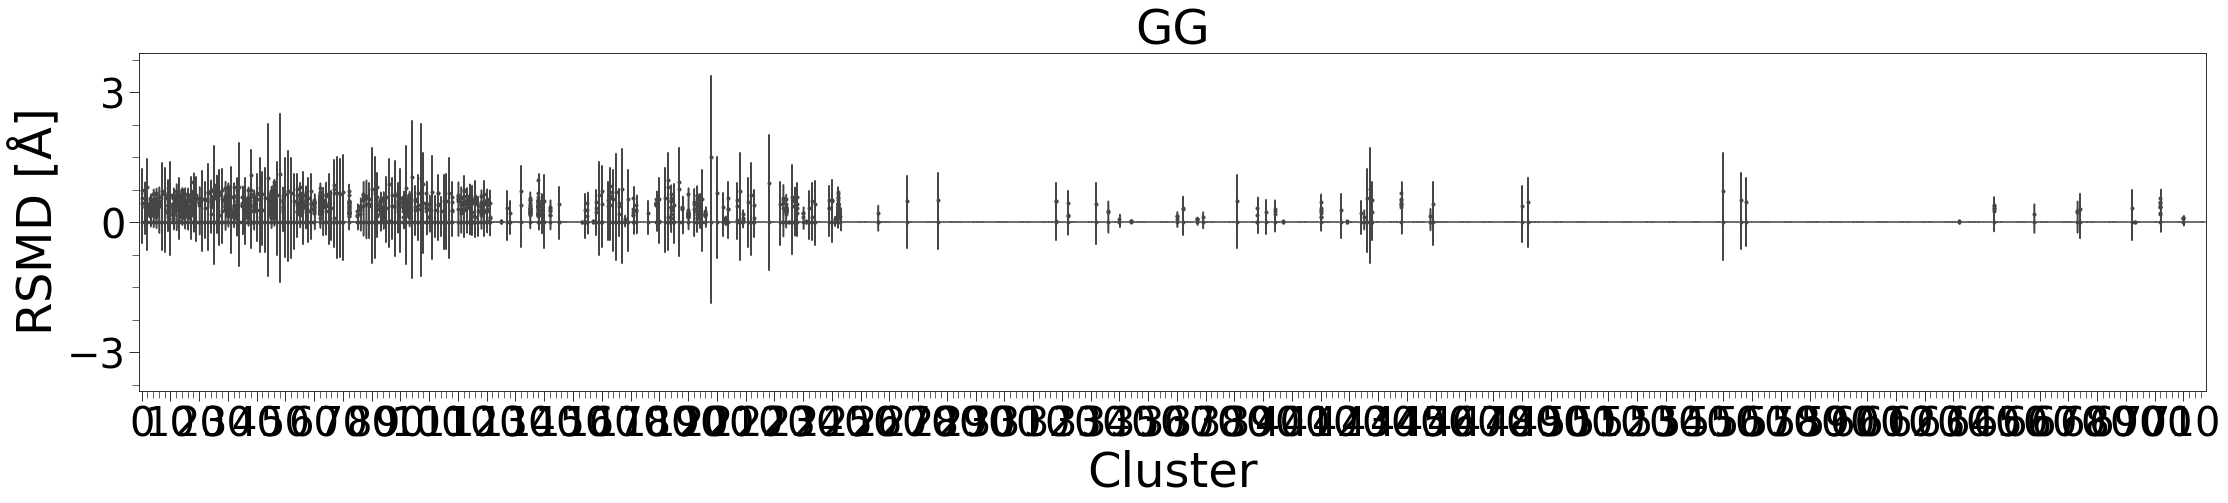

GC: 2731 files found
cluster #(array([1, 4]),): Found 5 samples but more than one index was assigned as centroid (308)
array: [0.03142521 0.03142499 0.03142521 0.12570005 0.03142499]
centroid_feature: [0.31812346 0.35720184 0.67730123 0.61585534 0.47017583 0.79738832
 0.70215213 0.6879099  0.98376071 1.10889983 0.27743199 0.86841249
 0.70560563 0.16025062 0.54263955 0.5635007  0.53845751 0.76904982
 0.83718097 0.67885315 0.62485969 0.38179481 0.5138014  0.42470971
 0.33499146 0.63214886 0.81966197 0.45477286 1.01671505 1.16045415
 0.99351919 0.85069925 1.11601257 1.30187678 0.83621204 1.07659721
 1.03019333 0.84076232 1.04540086 1.06557834 0.45721665 0.55498344
 0.55538207 0.7310909  0.76535171 0.30739012 0.35745385 0.39156511
 0.60844052 0.27497998 0.49406576 0.84196174 0.33228379 0.66772711
 0.45514974]
feature1: [0.35871693 0.30007023 0.67479664 0.6525755  0.493765   0.55880916
 0.86768293 0.8721138  0.8143277  0.7542233  0.27498916 0.843627
 0.798278   0.160558   0.43585187 0.61744

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506
# of samples,3.0,84.0,48.0,26.0,73.0,7.0,3.0,54.0,2.0,5.0,61.0,5.0,7.0,982.0,2.0,12.0,13.0,92.0,6.0,73.0,115.0,2.0,2.0,3.0,5.0,2.0,2.0,4.0,2.0,2.0,2.0,7.0,16.0,7.0,16.0,4.0,3.0,4.0,21.0,5.0,2.0,13.0,2.0,3.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,1.0,2.0,8.0,2.0,17.0,10.0,1.0,9.0,4.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,7.0,4.0,3.0,2.0,3.0,1.0,2.0,2.0,6.0,32.0,2.0,9.0,1.0,1.0,195.0,34.0,5.0,14.0,2.0,7.0,4.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0,1.0,1.0,2.0,3.0,1.0,3.0,6.0,3.0,1.0,3.0,4.0,3.0,1.0,1.0,3.0,3.0,2.0,67.0,1.0,3.0,1.0,1.0,4.0,71.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,2.0,3.0,4.0,10.0,4.0,6.0,1.0,4.0,1.0,1.0,1.0,1.0,6.0,1.0,10.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,5.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,60.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0
Avg,0.3,0.

<Figure size 4608x576 with 0 Axes>

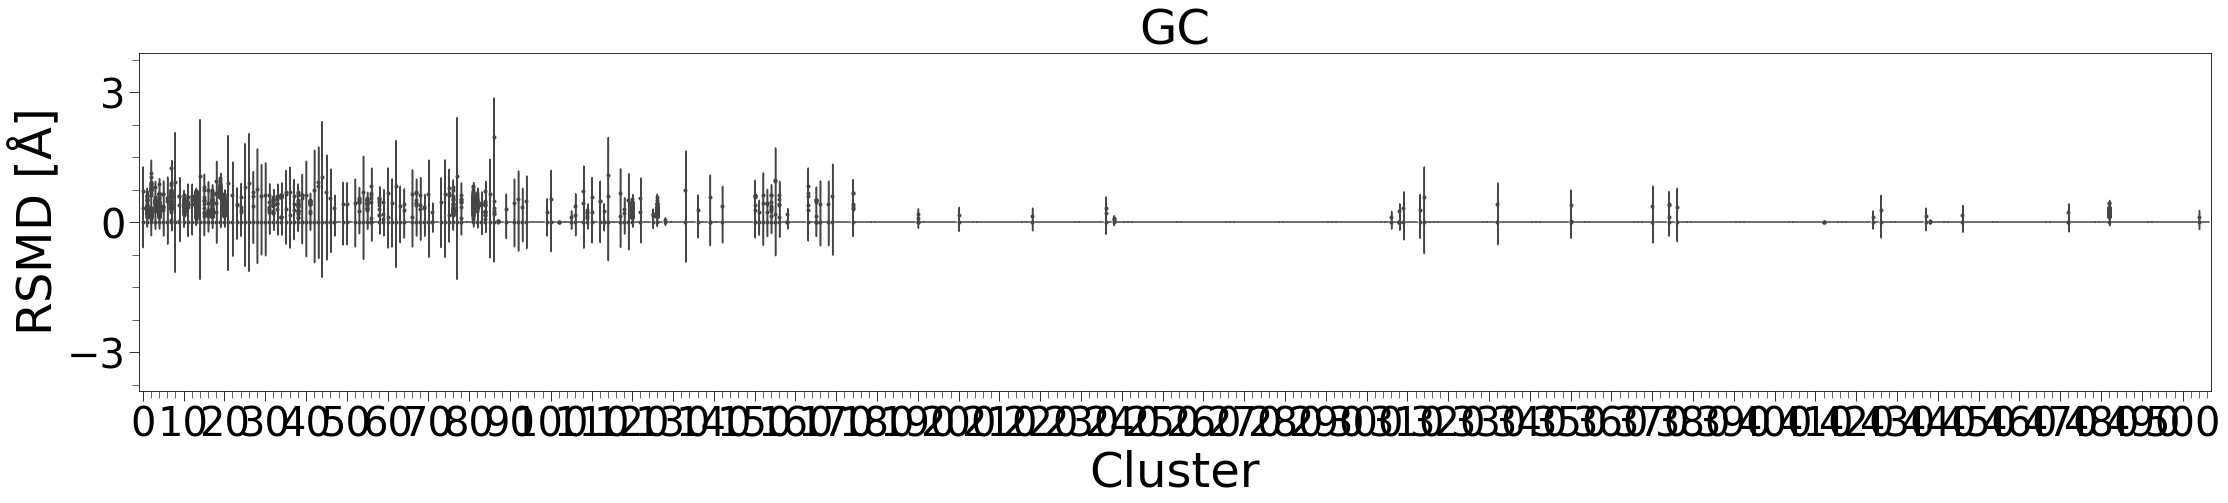

GA: 6968 files found
933 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932
# of samples,3.0,102.0,2.0,2.0,50.0,143.0,8.0,95.0,210.0,75.0,93.0,21.0,32.0,28.0,22.0,3.0,27.0,9.0,2.0,30.0,8.0,8.0,4.0,3.0,4.0,58.0,7.0,68.0,74.0,10.0,2.0,2.0,6.0,3.0,2.0,5.0,3.0,2.0,17.0,16.0,4.0,8.0,2.0,9.0,17.0,6.0,30.0,222.0,11.0,3.0,31.0,6.0,40.0,20.0,37.0,62.0,2.0,3.0,2.0,42.0,10.0,25.0,3.0,3.0,1295.0,3.0,355.0,5.0,2.0,9.0,4.0,87.0,5.0,4.0,31.0,2.0,2.0,4.0,2.0,3.0,2.

<Figure size 4608x576 with 0 Axes>

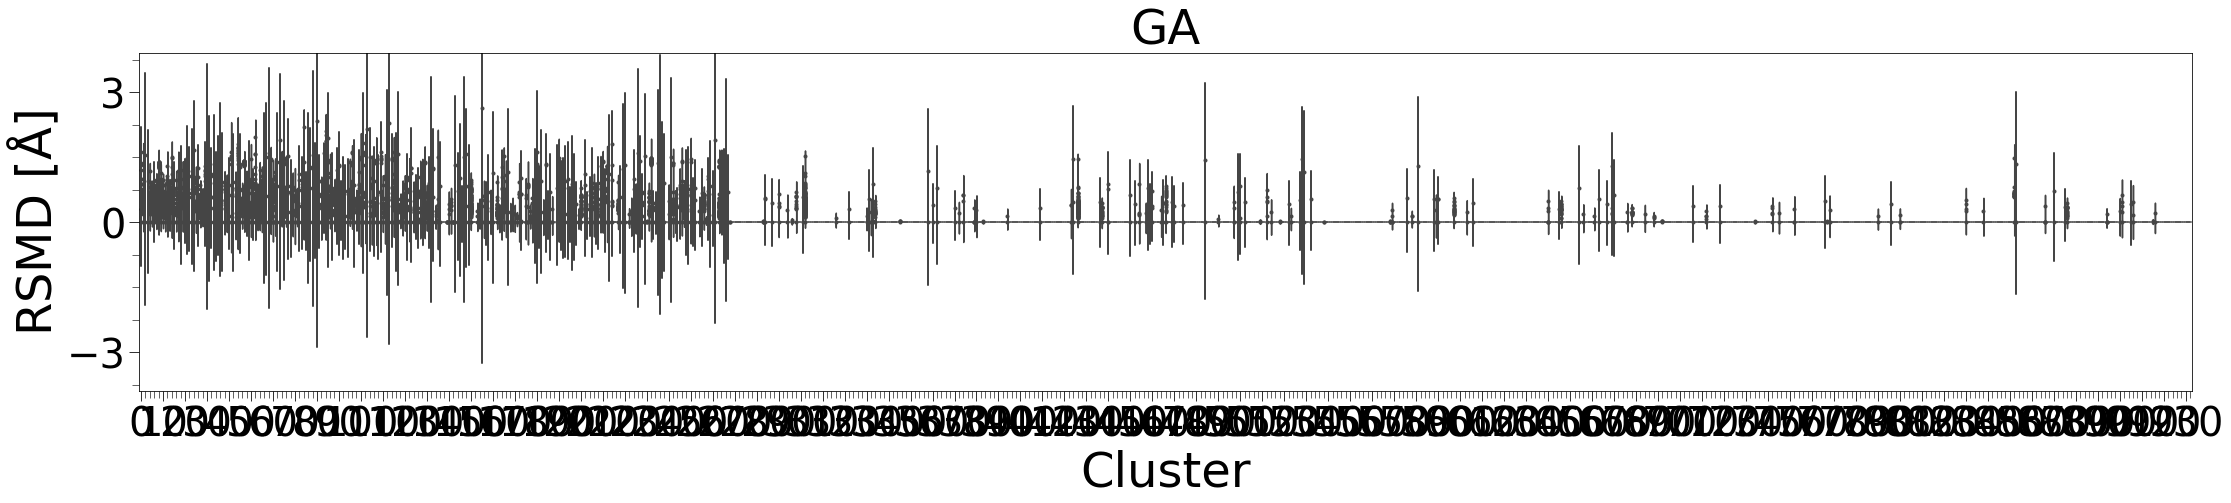

GU: 3209 files found
728 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727
# of samples,2.0,3.0,96.0,2.0,2.0,13.0,211.0,23.0,29.0,3.0,10.0,5.0,7.0,31.0,6.0,3.0,49.0,123.0,34.0,3.0,114.0,18.0,7.0,8.0,2.0,5.0,3.0,2.0,93.0,14.0,3.0,4.0,6.0,7.0,5.0,2.0,55.0,2.0,12.0,3.0,755.0,60.0,2.0,4.0,8.0,5.0,3.0,9.0,2.0,2.0,10.0,2.0,2.0,2.0,2.0,48.0,66.0,24.0,2.0,50.0,13.0,4.0,2.0,3.0,2.0,3.0,2.0,8.0,8.0,2.0,3.0,2.0,23.0,4.0,4.0,3.0,11.0,2.0,4.0,3.0,2.0,2.0,4.0,5.0,2.0,3.0,6.0,4.0,2.0,7.0,4.0,2.0,2.0,4.0,2.0,4.0,5.0,2.0,2.0,2.0,21.0,33.0,3.0,45.0,10.0,2.0,2.0,5.0,3.0,2.0,3.0,2.0,2.0,2.0,5.0,1.0,4.0,56.0,2.0,3.0,2.0,3.0,10.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,4.0,1.0,24.0,2.0,1.0,1.0,3.0,1.0,2.0,1.0,3.0,3.0,6.0,2.0,50.0,7.0,2.0,1.0,2.0,5.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,28.0,36.0,13.0,2.0,2.0,2.0,6.0,1.0,17.0,7.0,5.0,1.0,4.0,1.0,4.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,2.0,1.0,5.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,10.0,2.0,6.0,2.0,20.0,4.0,3.0,2.0,3.0,1.0,1.0,2.0,3.0,8.0,3.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0,1.0,5.0,2.0,8.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

<Figure size 4608x576 with 0 Axes>

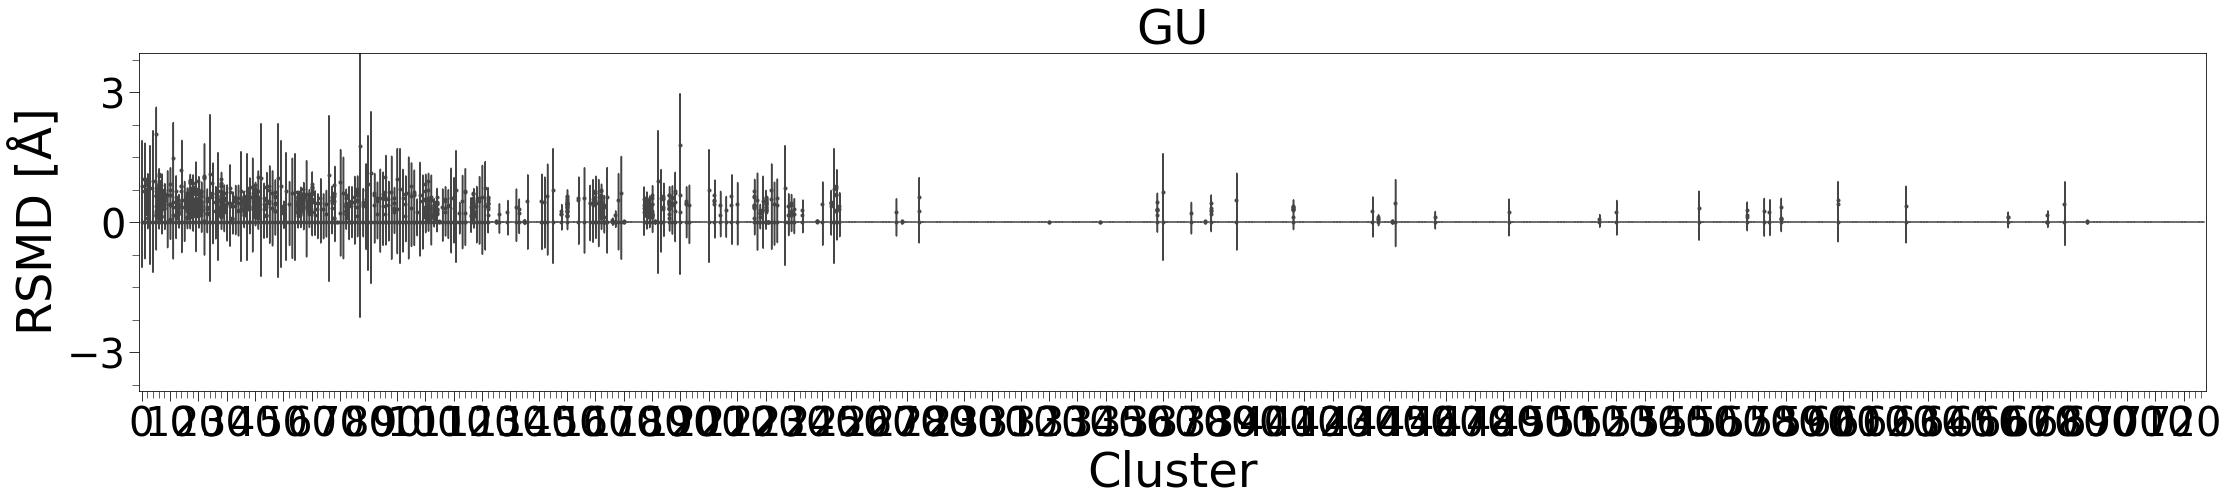

CG: 4143 files found
599 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598
# of samples,3.0,1057.0,18.0,4.0,2.0,10.0,89.0,22.0,29.0,42.0,59.0,52.0,8.0,37.0,6.0,2.0,2.0,80.0,15.0,4.0,2.0,6.0,221.0,5.0,16.0,2.0,9.0,3.0,11.0,6.0,2.0,16.0,4.0,223.0,14.0,3.0,2.0,3.0,40.0,3.0,4.0,2.0,17.0,10.0,3.0,2.0,15.0,2.0,9.0,3.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0,3.0,8.0,5.0,3.0,3.0,4.0,2.0,7.0,2.0,7.0,2.0,4.0,2.0,873.0,4.0,2.0,27.0,3.0,2.0,2.0,2.0,2.0,4.0,2.0,3.0,2.0,3.0,7.0,5.0,3.0,5.0,2.0,20.0,2.0,26.0,2.0,21.0,3.0,3.0,3.0,1.0,11.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,26.0,3.0,2.0,1.0,3.0,2.0,1.0,1.0,6.0,1.0,1.0,2.0,5.0,2.0,2.0,2.0,1.0,2.0,1.0,4.0,3.0,3.0,21.0,3.0,1.0,8.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,14.0,1.0,1.0,2.0,16.0,4.0,6.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,4.0,5.0,4.0,1.0,6.0,9.0,33.0,4.0,1.0,3.0,4.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,14.0,5.0,4.0,1.0,14.0,1.0,1.0,3.0,9.0,3.0,3.0,1.0,17.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,167.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,33.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

<Figure size 4608x576 with 0 Axes>

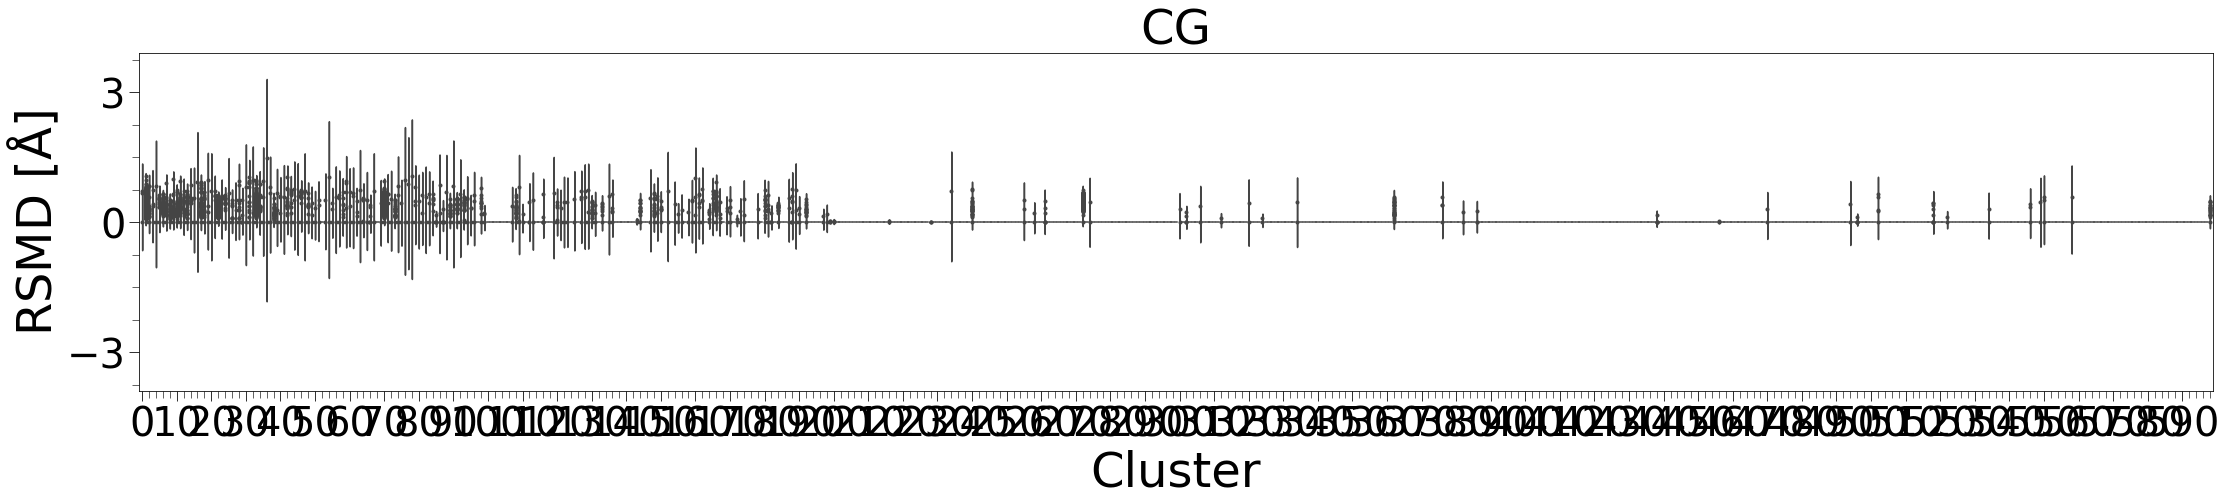

CC: 2386 files found
cluster #(array([2, 4]),): Found 5 samples but more than one index was assigned as centroid (110)
array: [0.06522404 0.06522404 0.06522398 0.260896   0.06522398]
centroid_feature: [0.30498099 0.35697368 0.39687449 0.6051091  0.45914236 0.520868
 0.80989838 0.83429277 0.7892729  0.65836173 0.27660537 0.49840063
 0.8385309  0.1606801  0.43414593 0.64324427 0.73173511 0.8161515
 0.82988626 0.33647454 0.66604602 0.36513838 0.65872383 0.90095967
 0.95901901 1.01677585 0.99023646 0.45206571 0.62713945 0.87426472
 1.11741614 1.18668056 1.18118751 1.02384198 0.98134214 1.09432626
 1.4044863  1.39707756 1.29152167 1.05225158 0.4288125  0.56932271
 0.68444496 0.83576679 0.92323762 0.35736895 0.31905538 0.4093143
 0.61199594 0.27357155 0.55500954 0.83117199 0.34939975 0.73639059
 0.45239133]
feature1: [0.35863057 0.32964376 0.40586412 0.61565614 0.4811742  0.58569705
 0.899905   0.88082385 0.7251378  0.57282615 0.27948326 0.54801315
 0.8282776  0.16114114 0.40268368 0.6299588

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451
# of samples,19.0,7.0,55.0,5.0,29.0,27.0,5.0,15.0,4.0,3.0,3.0,8.0,2.0,25.0,141.0,30.0,473.0,4.0,5.0,4.0,82.0,6.0,2.0,10.0,7.0,3.0,109.0,2.0,57.0,5.0,7.0,11.0,3.0,421.0,3.0,7.0,2.0,1.0,2.0,3.0,20.0,70.0,4.0,4.0,43.0,6.0,4.0,3.0,2.0,2.0,2.0,5.0,128.0,3.0,4.0,2.0,3.0,89.0,2.0,2.0,5.0,4.0,2.0,3.0,4.0,2.0,2.0,3.0,2.0,4.0,8.0,1.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,2.0,5.0,2.0,1.0,1.0,2.0,1.0,5.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,3.0,5.0,1.0,23.0,1.0,3.0,1.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,4.0,2.0,1.0,2.0,1.0,4.0,1.0,2.0,3.0,4.0,6.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,5.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,3.0,1.0,4.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,6.0,1.0
Avg,0.6,0.2,0.4,0.4,0.6,0.5,0.4,0.5,0.2,0.4,0.5,0.5,0.4,0.4,0.3,0.4,0.4,0.3,0.3,0.3,0.3,0.6,0.5,0.4,0.2,0.2,0.3,0.4,0.4,0.4,0.7,0.3,0.4,0.4,0.3,0.4,0.3,0.0,0.7,0.3,0.4,0.3,0.4,0.4,0.3,0.6,0.5,0.4,0.3,0.2,0.1,0.3,0.3,0.9,0.3,0.3,0.3,0.4,0.3,0.2,0.4,0.5,0.2,0.3,0.4,0.4,0.3,0.3,0.3,0.3,0.3,0.0,0.1,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.2,0.4,0.0,0.0,0.2,0.0,0.4,0.0,0.0,0.1,0.0,0.0,0.4,0.1,0.0,0.4,0.3,0.0,0.0,0.2,0.0,0.5,0.3,0.0,0.0,0.2,0.2,0.0,0.

<Figure size 4608x576 with 0 Axes>

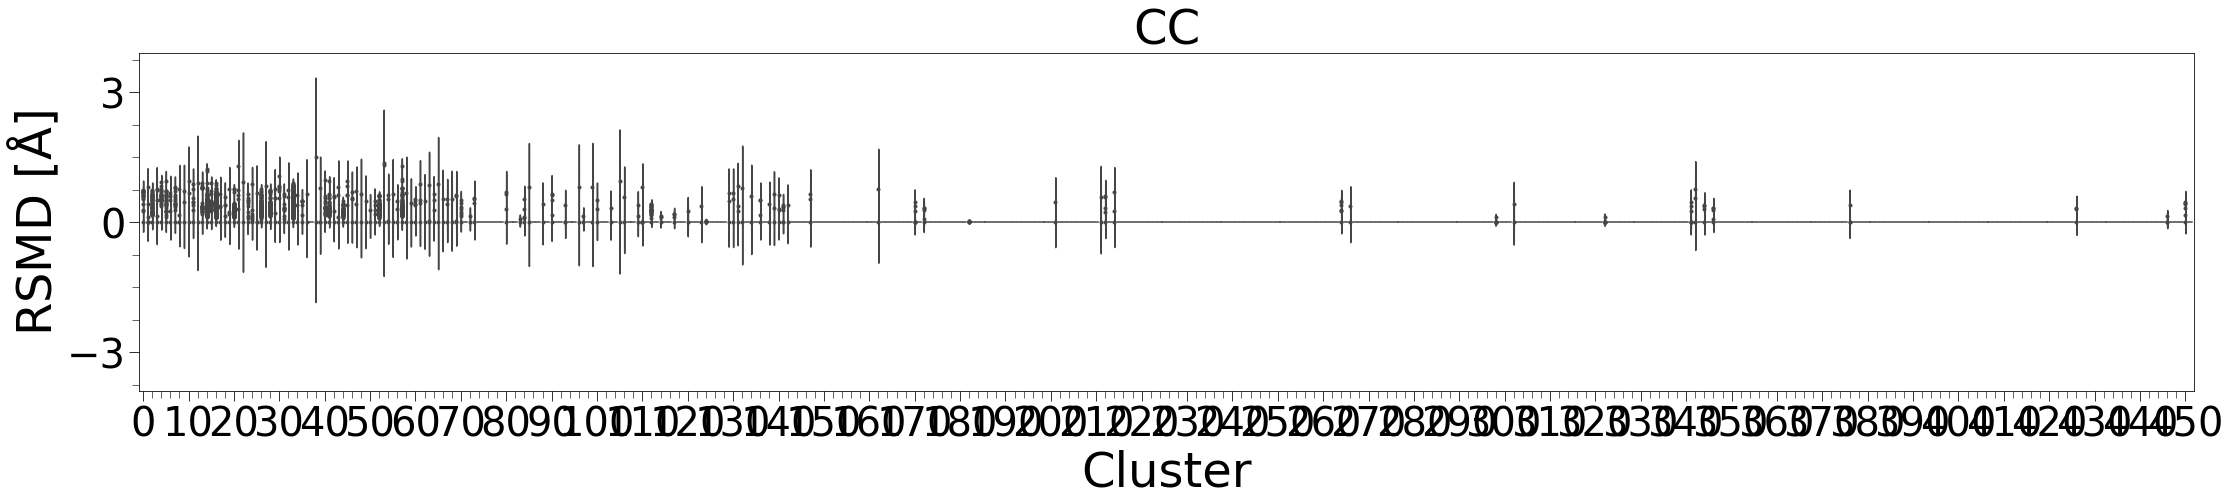

CA: 4545 files found
531 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530
# of samples,16.0,2.0,2.0,2.0,7.0,2.0,95.0,60.0,7.0,210.0,103.0,3.0,43.0,2.0,10.0,2.0,27.0,89.0,6.0,60.0,3.0,23.0,143.0,3.0,5.0,9.0,15.0,7.0,4.0,2.0,3.0,27.0,64.0,3.0,6.0,3.0,3.0,3.0,2.0,6.0,2.0,4.0,6.0,137.0,3.0,13.0,6.0,9.0,15.0,3.0,2.0,7.0,3.0,4.0,45.0,2.0,2.0,3.0,9.0,4.0,7.0,2.0,8.0,3.0,4.0,2.0,3.0,3.0,13.0,3.0,14.0,14.0,9.0,2.0,5.0,5.0,3.0,2.0,27.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0,4.0,2.0,3.0,15.0,2.0,196.0,11.0,1.0,151.0,1.0,6.0,3.0,2.0,4.0,1.0,15.0,3.0,2.0,171.0,4.0,5.0,1713.0,1.0,1.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,5.0,1.0,1.0,4.0,1.0,9.0,3.0,3.0,1.0,1.0,12.0,1.0,85.0,1.0,1.0,2.0,118.0,1.0,4.0,1.0,1.0,1.0,3.0,20.0,4.0,2.0,24.0,5.0,2.0,48.0,3.0,2.0,4.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,3.0,1.0,1.0,1.0,11.0,1.0,1.0,1.0,1.0,1.0,17.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,47.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,1.0,1.0,22.0,1.0,1.0,1.0,1.0,3.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,4.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

<Figure size 4608x576 with 0 Axes>

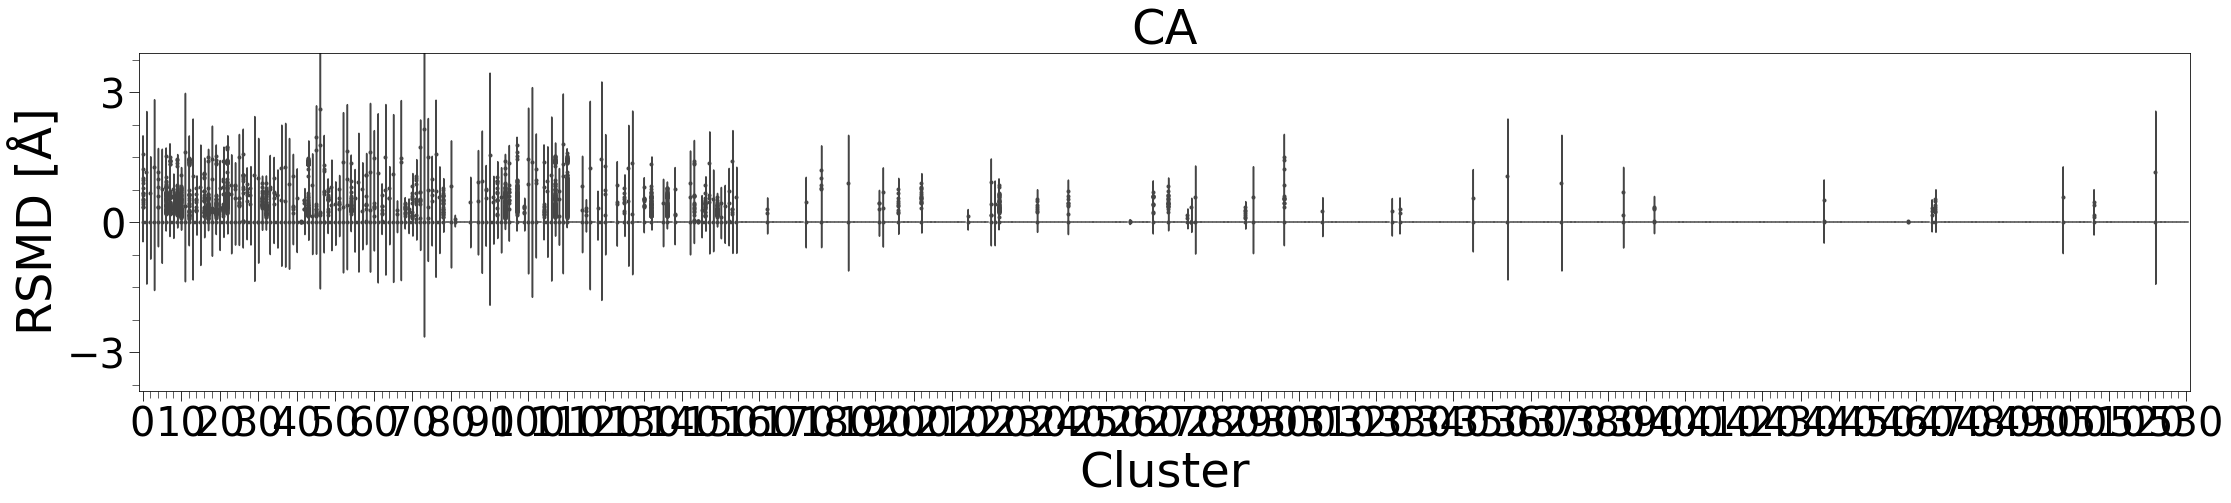

CU: 3386 files found
cluster #(array([0, 2]),): Found 3 samples but more than one index was assigned as centroid (95)
array: [0.12343369 0.24686752 0.12343369]
centroid_feature: [0.30626416 0.35645214 0.40294579 0.60670042 0.44917044 0.61454344
 0.49270746 0.66570789 0.68855733 0.62153763 0.27232501 0.45433649
 0.82451957 0.16014577 0.52311188 0.38362429 0.6242094  0.76815176
 0.77023667 0.26043546 0.64902085 0.39679253 0.7781558  0.55289769
 0.81547004 0.96770734 0.95010668 0.45342472 0.59942645 0.86438388
 0.57761437 0.81394047 0.96771318 1.00375068 0.9831655  1.1653924
 0.93001872 1.09321201 1.12549746 1.08654046 0.48736903 0.41935763
 0.64108181 0.80212992 0.81045181 0.35902801 0.30445054 0.40569377
 0.60646439 0.2787061  0.56919026 0.79398704 0.38940832 0.74865752
 0.45141923]
feature1: [0.36072153 0.30320525 0.40907812 0.6144714  0.48961452 0.5916794
 0.8839554  0.90325963 0.8379979  0.75964785 0.28198734 0.5622164
 0.78962326 0.1601568  0.46365207 0.6272203  0.7430497  0.8196985

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539
# of samples,20.0,28.0,2.0,3.0,3.0,3.0,27.0,2.0,130.0,9.0,6.0,7.0,4.0,2.0,3.0,9.0,8.0,7.0,4.0,5.0,786.0,2.0,47.0,15.0,2.0,3.0,7.0,2.0,2.0,2.0,7.0,5.0,18.0,6.0,29.0,4.0,5.0,89.0,8.0,25.0,5.0,18.0,2.0,3.0,3.0,2.0,4.0,24.0,4.0,2.0,3.0,2.0,2.0,3.0,4.0,11.0,8.0,2.0,2.0,3.0,846.0,2.0,3.0,4.0,49.0,8.0,2.0,5.0,2.0,4.0,36.0,4.0,15.0,7.0,6.0,3.0,8.0,4.0,14.0,8.0,12.0,213.0,31.0,1.0,1.0,7.0,11.0,1.0,64.0,2.0,1.0,1.0,1.0,1.0,5.0,3.0,2.0,1.0,3.0,6.0,1.0,2.0,2.0,2.0,1.0,2.0,5.0,2.0,2.0,6.0,4.0,1.0,6.0,25.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,2.0,3.0,1.0,1.0,2.0,3.0,1.0,3.0,17.0,2.0,1.0,4.0,1.0,2.0,6.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,5.0,1.0,2.0,1.0,17.0,1.0,9.0,3.0,1.0,9.0,2.0,32.0,1.0,4.0,2.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,7.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,79.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0,1.0,1.

<Figure size 4608x576 with 0 Axes>

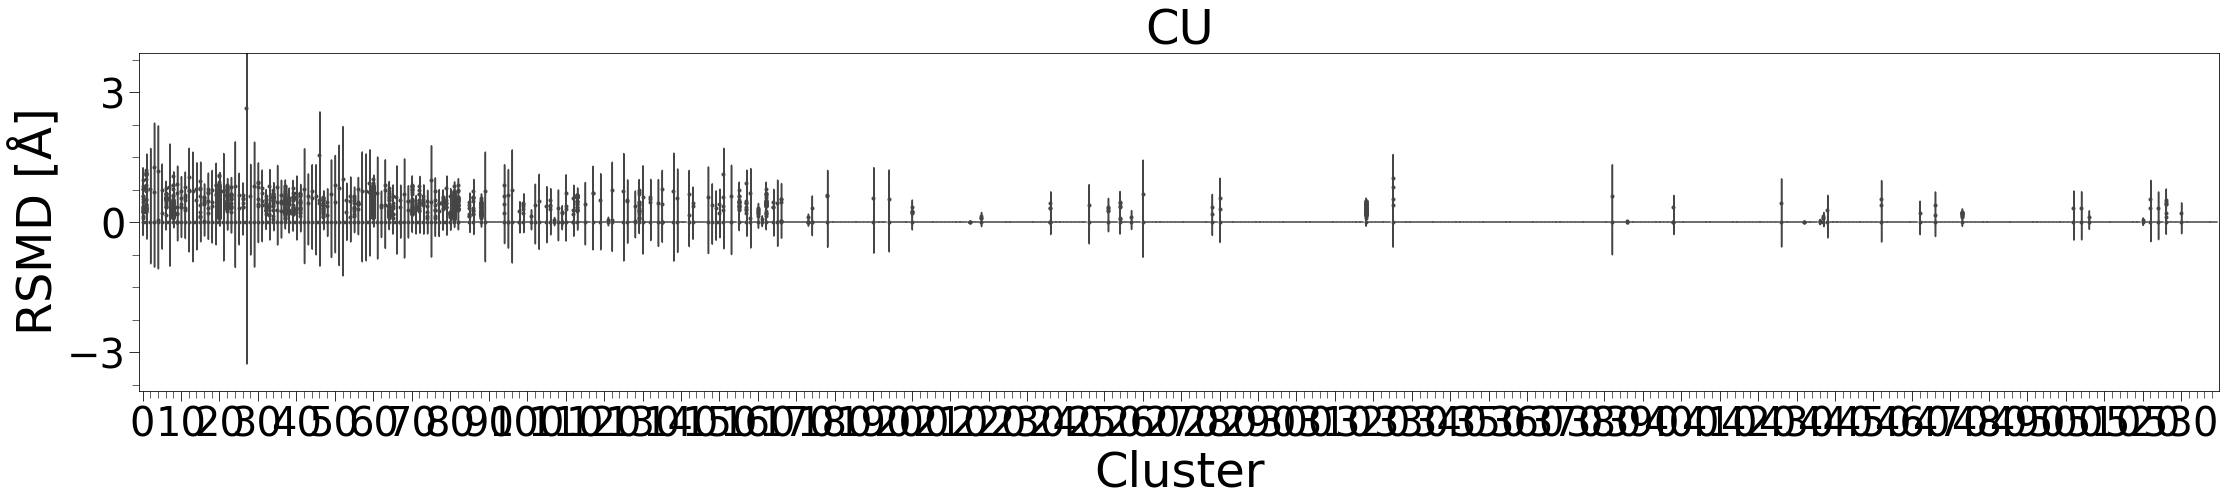

AG: 5678 files found
669 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668
# of samples,49.0,5.0,24.0,187.0,30.0,4.0,5.0,155.0,43.0,49.0,2.0,57.0,42.0,15.0,6.0,2.0,4.0,17.0,25.0,3.0,3.0,7.0,72.0,6.0,10.0,3.0,2.0,2.0,28.0,721.0,5.0,4.0,5.0,26.0,4.0,8.0,104.0,77.0,46.0,7.0,150.0,4.0,65.0,2.0,1775.0,7.0,39.0,3.0,2.0,29.0,135.0,3.0,2.0,3.0,3.0,61.0,6.0,65.0,2.0,9.0,8.0,2.0,4.0,1.0,6.0,6.0,8.0,2.0,5.0,2.0,5.0,52.0,11.0,3.0,35.0,22.0,22.0,3.0,93.0,2.0,2.0,2.0,3.0,3.0,18.0,3.0,3.0,12.0,2.0,6.0,3.0,36.0,10.0,2.0,4.0,4.0,12.0,3.0,2.0,20.0,4.0,2.0,2.0,2.0,172.0,5.0,5.0,3.0,2.0,4.0,1.0,1.0,1.0,3.0,20.0,14.0,32.0,7.0,3.0,1.0,4.0,2.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,3.0,2.0,1.0,5.0,4.0,5.0,3.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,4.0,1.0,2.0,1.0,2.0,2.0,6.0,5.0,3.0,1.0,7.0,1.0,1.0,31.0,2.0,3.0,6.0,2.0,1.0,1.0,3.0,2.0,1.0,1.0,7.0,1.0,3.0,2.0,4.0,1.0,1.0,1.0,2.0,4.0,4.0,4.0,63.0,6.0,1.0,2.0,2.0,3.0,2.0,2.0,4.0,2.0,5.0,4.0,5.0,2.0,3.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,9.0,4.0,4.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,1.0,1.0,1.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,

<Figure size 4608x576 with 0 Axes>

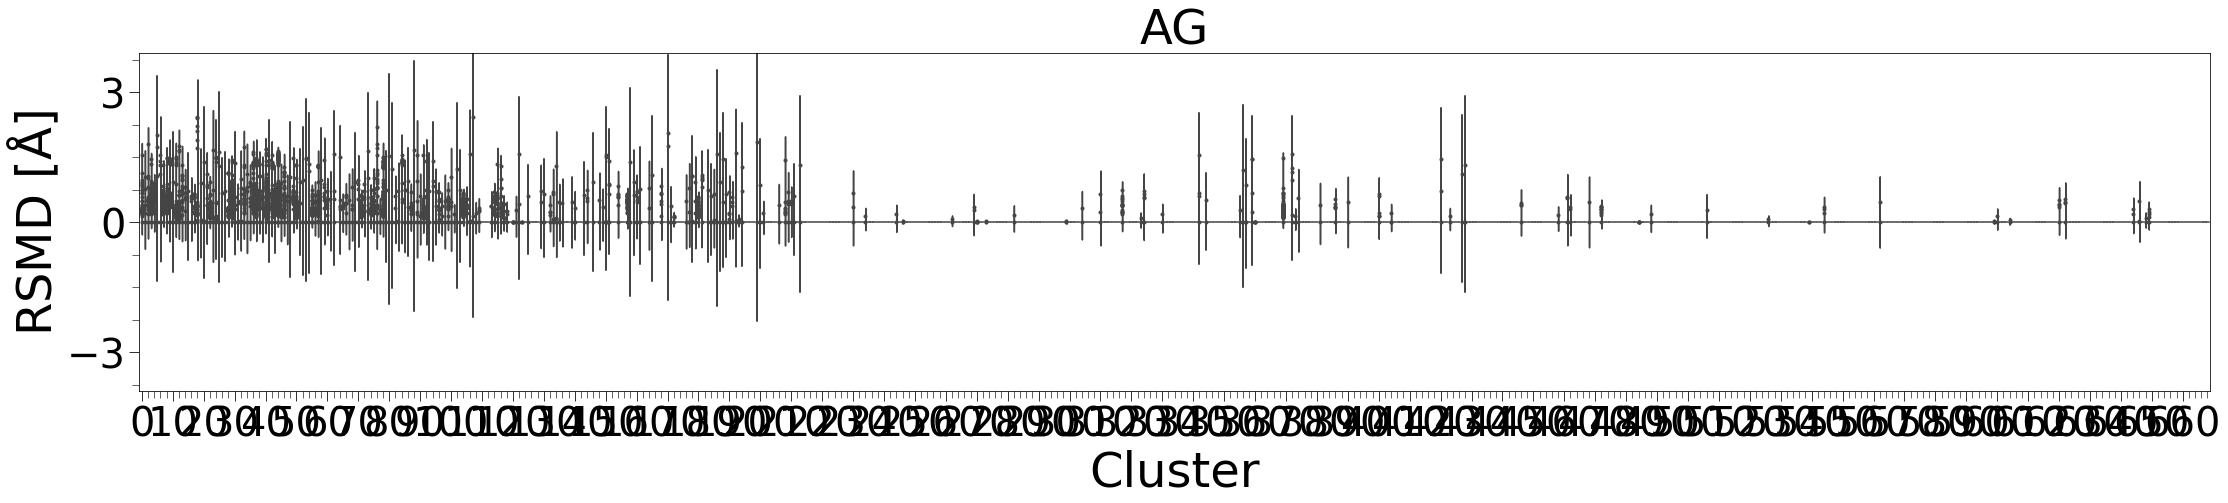

AC: 4338 files found
462 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461
# of samples,2.0,704.0,2.0,4.0,7.0,4.0,209.0,16.0,18.0,6.0,2.0,7.0,2.0,24.0,100.0,17.0,24.0,6.0,4.0,4.0,18.0,151.0,6.0,2.0,4.0,4.0,3.0,250.0,3.0,2.0,7.0,210.0,14.0,78.0,5.0,1227.0,25.0,3.0,6.0,210.0,4.0,11.0,3.0,22.0,3.0,58.0,4.0,75.0,9.0,4.0,2.0,2.0,2.0,2.0,21.0,2.0,7.0,7.0,2.0,5.0,8.0,4.0,6.0,28.0,2.0,9.0,2.0,1.0,1.0,2.0,6.0,4.0,1.0,3.0,13.0,1.0,2.0,1.0,5.0,39.0,2.0,2.0,47.0,8.0,8.0,1.0,5.0,2.0,2.0,1.0,2.0,9.0,5.0,2.0,3.0,2.0,4.0,5.0,4.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,5.0,2.0,4.0,1.0,2.0,2.0,3.0,4.0,1.0,1.0,5.0,2.0,3.0,2.0,2.0,15.0,1.0,1.0,2.0,18.0,1.0,1.0,4.0,109.0,2.0,11.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,6.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,7.0,3.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,38.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,9.0,13.0,1.0,1.0,1.0,15.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0
Avg,0.5,0.4,0.3,0.4,0.5,0.8,0.4,0.6,0.8,0.3,0.4,1.0,1.0,0.7,0.3,0.4,0.5,1.2,0.4,0.9,0.6,0.4,1.1,0.6,1.2,0.8,0.8,0.5,0.7,0.7,0.7,0.5,0.5,0.5,0.6,0.4,0.5,0.2,0.5,0.4,0.4,0.8,0.6,0.5,1.0,0.5,0.6,0.6,0.4,0.4,0.4,0.6,0.5,0.4,0.7,0.4,0.6,0.4,0.4,0.3,0.4,0.3,0.3,0.6,0.9,0.5,0.4,0.0,0.0,0.0,0.3,0.8,0.0,0.5,0.3,0.0,0.5,0.0,0.4,0.5,0.4,0.6,0.4,0.5,0.4,0.0,0.4,0.3,0

<Figure size 4608x576 with 0 Axes>

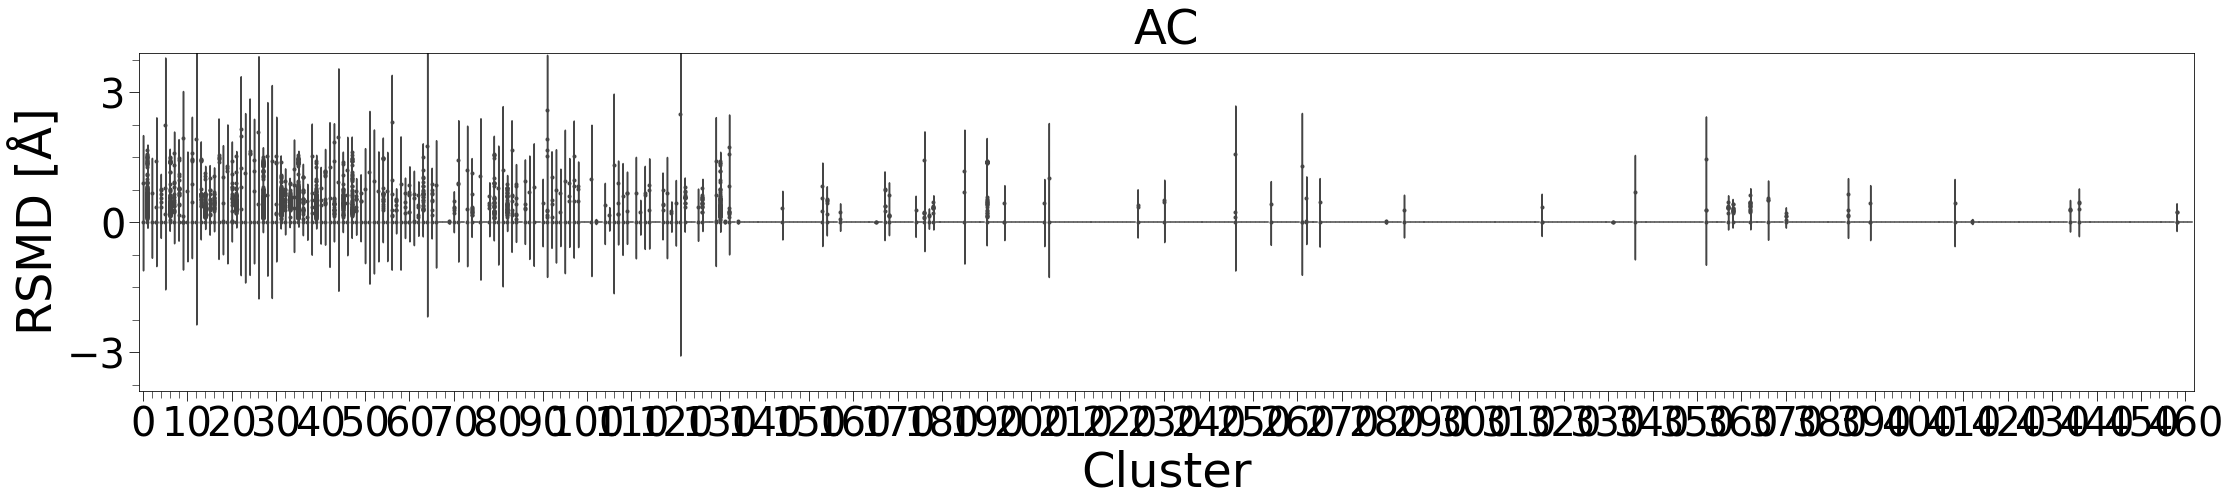

AA: 7720 files found
cluster #(array([0, 3]),): Found 5 samples but more than one index was assigned as centroid (83)
array: [0.12833278 0.27456885 0.14421278 0.12833278 0.23734602]
centroid_feature: [0.31378192 0.35730293 0.67847174 0.45836824 0.75109732 0.91407454
 1.02879643 0.81233943 0.27975726 0.89575112 0.16106451 0.4868744
 0.65260684 0.76198399 0.76853597 0.70486587 0.36282372 0.48025528
 0.64871502 0.72461045 0.52237028 1.02064741 1.10716283 1.29243445
 1.33363545 0.70912009 0.39935175 0.55375296 0.66176373 0.81174624
 0.35721827 0.31741858 0.661614   0.27009404 0.85380048 0.78934371]
feature1: [0.30873424 0.3576953  0.6597131  0.44615662 0.6405275  0.59468603
 0.43129203 0.87213194 0.2717572  0.88031286 0.16013569 0.42313498
 0.47037378 0.41413933 0.8321237  0.6920849  0.40501377 0.56370455
 0.45331094 0.48223105 1.0593889  1.038603   1.1342009  0.9103208
 0.8472997  1.4355907  0.4049893  0.5459056  0.50866956 0.80046684
 0.30788362 0.35783842 0.68281955 0.27459168 0.8792581

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596
# of samples,6.0,42.0,227.0,71.0,6.0,15.0,2.0,6.0,6.0,185.0,16.0,8.0,17.0,5.0,30.0,315.0,2.0,44.0,4.0,58.0,2.0,7.0,2.0,7.0,23.0,102.0,12.0,2.0,39.0,2963.0,4.0,4.0,2.0,3.0,138.0,12.0,3.0,4.0,3.0,7.0,6.0,16.0,147.0,7.0,14.0,210.0,22.0,12.0,6.0,8.0,4.0,7.0,7.0,24.0,93.0,84.0,4.0,6.0,10.0,2.0,4.0,2.0,5.0,13.0,9.0,4.0,35.0,9.0,7.0,126.0,123.0,14.0,16.0,6.0,2.0,96.0,3.0,3.0,6.0,3.0,10.0,3.0,25.0,5.0,2.0,3.0,6.0,3.0,3.0,6.0,61.0,3.0,145.0,73.0,3.0,2.0,17.0,33.0,2.0,12.0,2.0,2.0,70.0,4.0,8.0,3.0,2.0,11.0,3.0,14.0,154.0,21.0,4.0,2.0,1.0,3.0,2.0,5.0,114.0,167.0,72.0,21.0,4.0,3.0,5.0,4.0,4.0,4.0,1.0,3.0,24.0,3.0,3.0,2.0,8.0,2.0,10.0,21.0,6.0,7.0,3.0,2.0,2.0,18.0,6.0,3.0,3.0,1.0,2.0,16.0,2.0,1.0,2.0,1.0,4.0,1.0,1.0,1.0,39.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0,6.0,1.0,4.0,1.0,1.0,2.0,6.0,1.0,4.0,4.0,3.0,66.0,8.0,1.0,1.0,1.0,1.0,29.0,2.0,2.0,44.0,2.0,2.0,117.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,4.0,1.0,20.0,1.0,1.0,2.0,4.0,1.0,2.0,1.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,3.0,3.0,4.0,3.0,3.0,86.0,2.0,4.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,5.0,1.0,1.0,2.0,6.0,151.0,4.0,3.0,19.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,5.0,1.0,1.0,34.0,8.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,4.0,2.0,2.0,2.0,5.0,14.0,1.0,2.0,8.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,4.0,2.0,1.0,1.0,3.0,8.0,1.0,1.0,7.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,4.0,2.0,1.0,4.0,1.0,15.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

<Figure size 4608x576 with 0 Axes>

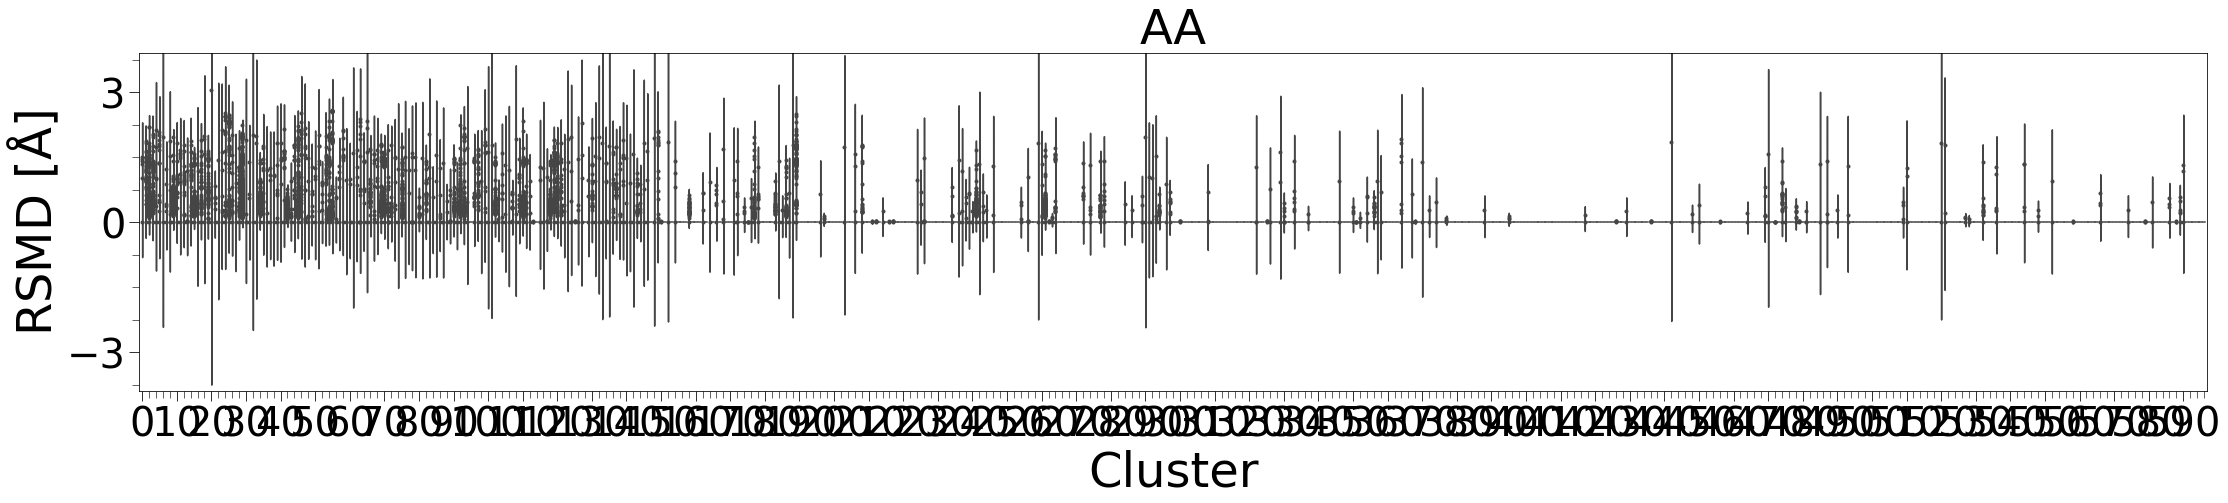

AU: 4030 files found
cluster #(array([0, 2]),): Found 3 samples but more than one index was assigned as centroid (231)
array: [0.09675822 0.19351641 0.09675822]
centroid_feature: [0.3565464  0.31376302 0.64096165 0.48104501 0.64789444 0.69842821
 0.92596823 0.87426353 1.20397449 0.27144888 0.84443444 0.16052774
 0.52139157 0.56449091 0.76629525 0.84284467 1.09358025 0.79998726
 0.41499555 0.62800574 0.55362457 0.80848217 0.9087677  1.23808455
 0.9000718  0.64327401 0.72797298 0.84559375 0.56414366 0.97116154
 0.47135046 0.56804675 0.72145826 0.80751568 0.99678212 0.31733713
 0.35852894 0.34639326 0.6143384  0.26958618 0.51664609 0.8413313
 0.43826786 0.65836018 0.45554027]
feature1: [0.35545513 0.30687657 0.6721822  0.4904583  0.7776319  0.6778112
 0.76421183 1.062215   1.1928859  0.26913545 0.85045785 0.15976106
 0.46688372 0.47823784 0.50722873 0.749119   0.84159875 0.77332276
 0.40885162 0.52109265 0.37719992 0.5169248  0.8067998  1.0180517
 0.90061456 1.1051962  1.072519   1.262577

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618
# of samples,2.0,10.0,13.0,132.0,2.0,2.0,12.0,348.0,47.0,3.0,2.0,2.0,133.0,133.0,52.0,2.0,2.0,2.0,2.0,8.0,4.0,18.0,41.0,7.0,2.0,2.0,63.0,2.0,133.0,14.0,2.0,3.0,2.0,6.0,22.0,2.0,9.0,2.0,4.0,1040.0,2.0,9.0,3.0,124.0,2.0,5.0,4.0,3.0,4.0,73.0,87.0,24.0,5.0,21.0,3.0,3.0,27.0,3.0,3.0,112.0,15.0,10.0,27.0,16.0,3.0,2.0,4.0,2.0,11.0,3.0,2.0,4.0,60.0,3.0,3.0,13.0,3.0,8.0,6.0,3.0,3.0,2.0,4.0,3.0,7.0,2.0,5.0,9.0,2.0,33.0,2.0,2.0,2.0,1.0,5.0,4.0,3.0,3.0,1.0,3.0,10.0,4.0,1.0,6.0,2.0,3.0,12.0,2.0,3.0,2.0,1.0,1.0,4.0,2.0,4.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,7.0,1.0,5.0,4.0,52.0,7.0,4.0,2.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,211.0,2.0,1.0,2.0,2.0,4.0,2.0,2.0,1.0,14.0,6.0,33.0,4.0,2.0,2.0,2.0,5.0,2.0,1.0,1.0,4.0,4.0,1.0,2.0,5.0,4.0,1.0,2.0,1.0,2.0,2.0,14.0,6.0,2.0,1.0,2.0,2.0,4.0,2.0,7.0,5.0,3.0,1.0,2.0,2.0,10.0,31.0,2.0,15.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,1.0,1.0,4.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,42.0,1.0,1.0,1.0,4.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1

<Figure size 4608x576 with 0 Axes>

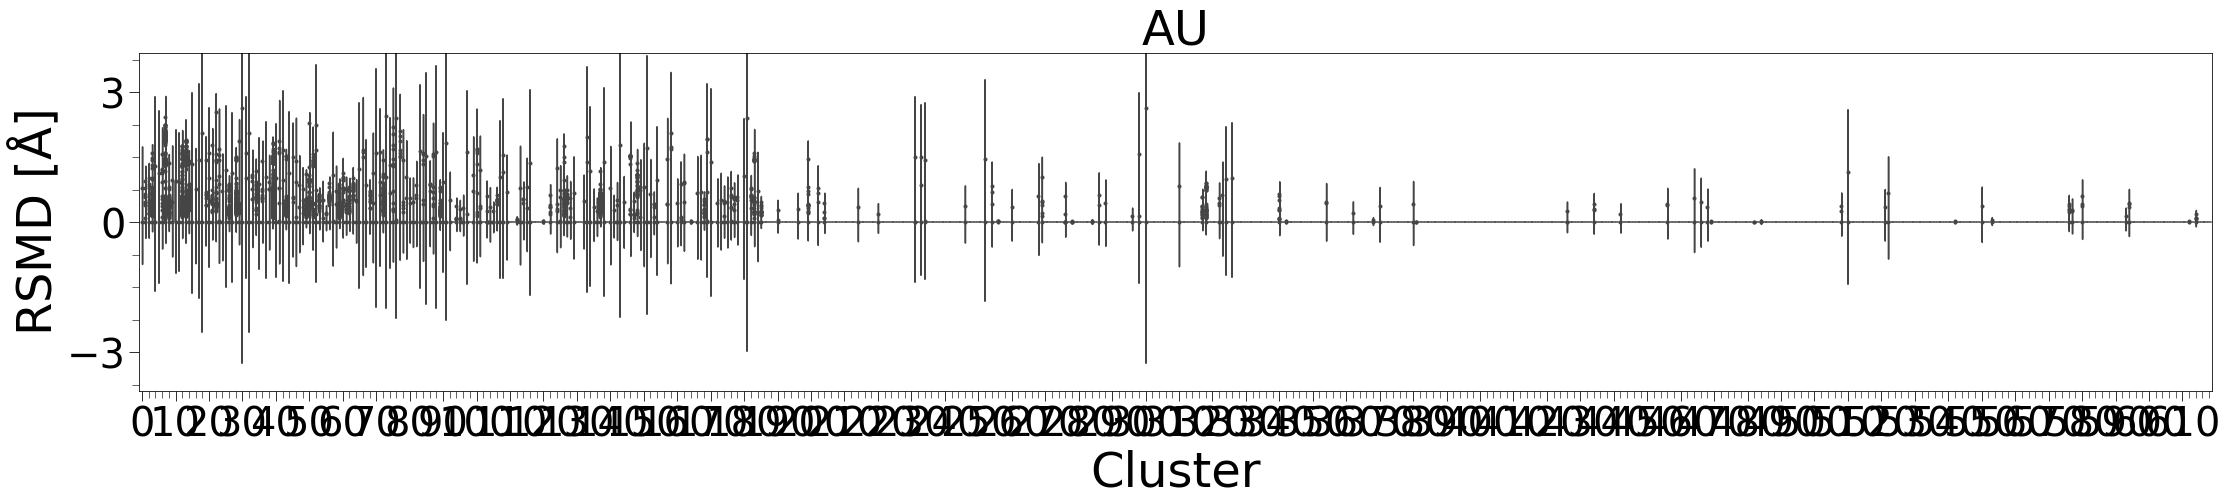

UG: 4060 files found
860 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859
# of samples,2.0,8.0,24.0,6.0,5.0,6.0,7.0,8.0,9.0,3.0,2.0,13.0,35.0,75.0,3.0,21.0,24.0,2.0,21.0,6.0,2.0,8.0,4.0,3.0,34.0,4.0,3.0,3.0,6.0,2.0,5.0,5.0,14.0,63.0,87.0,3.0,3.0,2.0,4.0,1058.0,10.0,2.0,7.0,16.0,33.0,6.0,6.0,2.0,8.0,16.0,25.0,4.0,3.0,8.0,2.0,30.0,8.0,2.0,26.0,16.0,122.0,4.0,87.0,328.0,2.0,13.0,4.0,14.0,20.0,7.0,2.0,2.0,30.0,2.0,33.0,2.0,13.0,14.0,17.0,5.0,4.0,12.0,2.0,3.0,39.0,4.0,3.0,9.0,7.0,5.0,1.0,2.0,3.0,1.0,3.0,4.0,6.0,5.0,3.0,144.0,3.0,22.0,6.0,3.0,7.0,1.0,3.0,5.0,3.0,4.0,4.0,6.0,27.0,2.0,3.0,4.0,1.0,2.0,3.0,2.0,3.0,2.0,11.0,8.0,31.0,4.0,4.0,11.0,4.0,171.0,45.0,27.0,5.0,1.0,1.0,1.0,1.0,5.0,2.0,1.0,1.0,3.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,1.0,2.0,1.0,

<Figure size 4608x576 with 0 Axes>

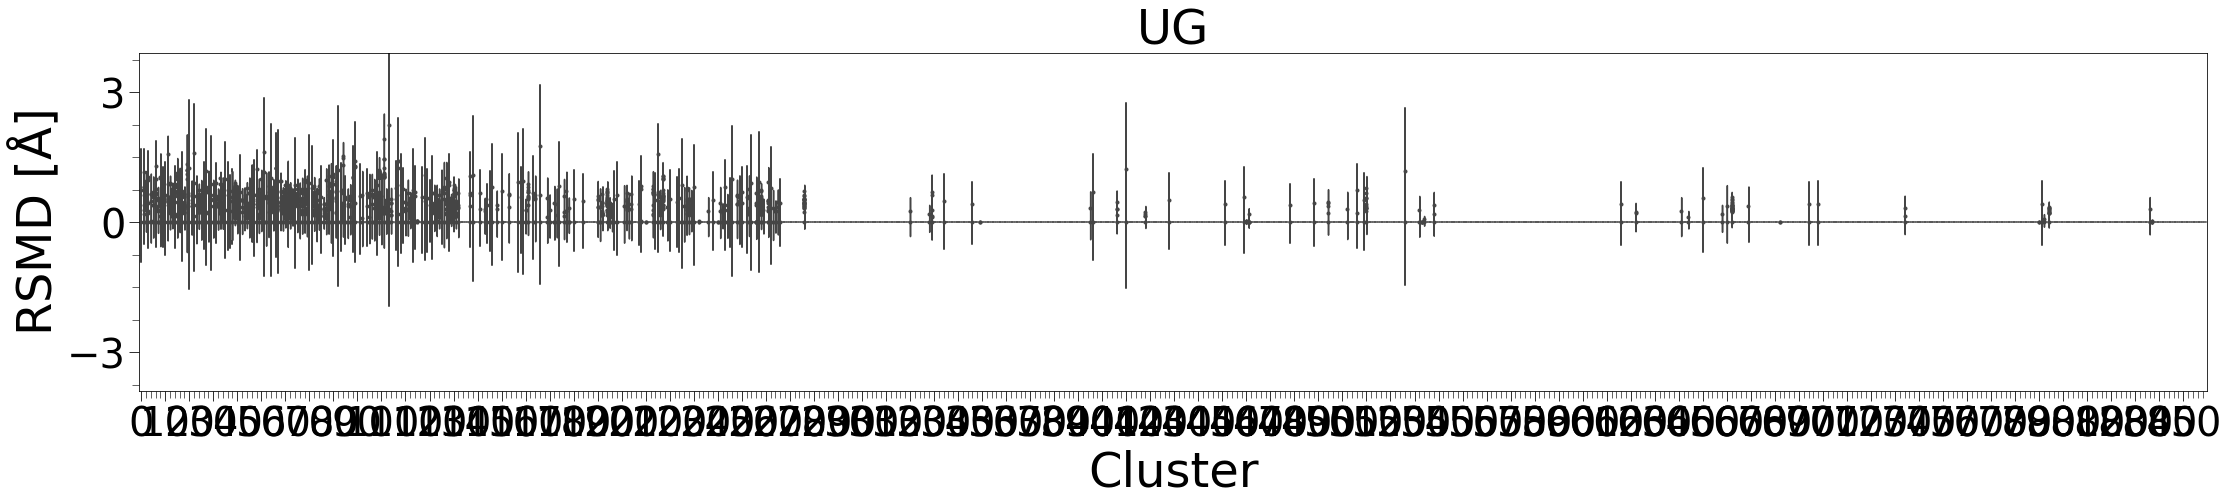

UC: 2633 files found
508 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507
# of samples,42.0,5.0,140.0,353.0,99.0,6.0,44.0,31.0,7.0,2.0,6.0,13.0,132.0,3.0,2.0,2.0,5.0,65.0,23.0,41.0,4.0,7.0,4.0,2.0,5.0,9.0,15.0,10.0,8.0,9.0,12.0,6.0,5.0,3.0,8.0,98.0,17.0,7.0,62.0,6.0,52.0,2.0,1.0,3.0,2.0,2.0,3.0,3.0,98.0,6.0,2.0,6.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,29.0,2.0,2.0,4.0,3.0,195.0,1.0,1.0,1.0,5.0,2.0,4.0,12.0,2.0,202.0,20.0,2.0,3.0,5.0,6.0,2.0,8.0,2.0,65.0,63.0,4.0,1.0,1.0,1.0,6.0,5.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,25.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,3.0,6.0,1.0,2.0,1.0,1.0,1.0,1.0,5.0,2.0,8.0,5.0,3.0,5.0,1.0,2.0,6.0,1.0,7.0,16.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,3.0,2.0,2.0,2.0,50.0,2.0,2.0,3.0,2.0,9.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,2.0,6.0,1.0,2.0,2.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,8.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,16.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1

<Figure size 4608x576 with 0 Axes>

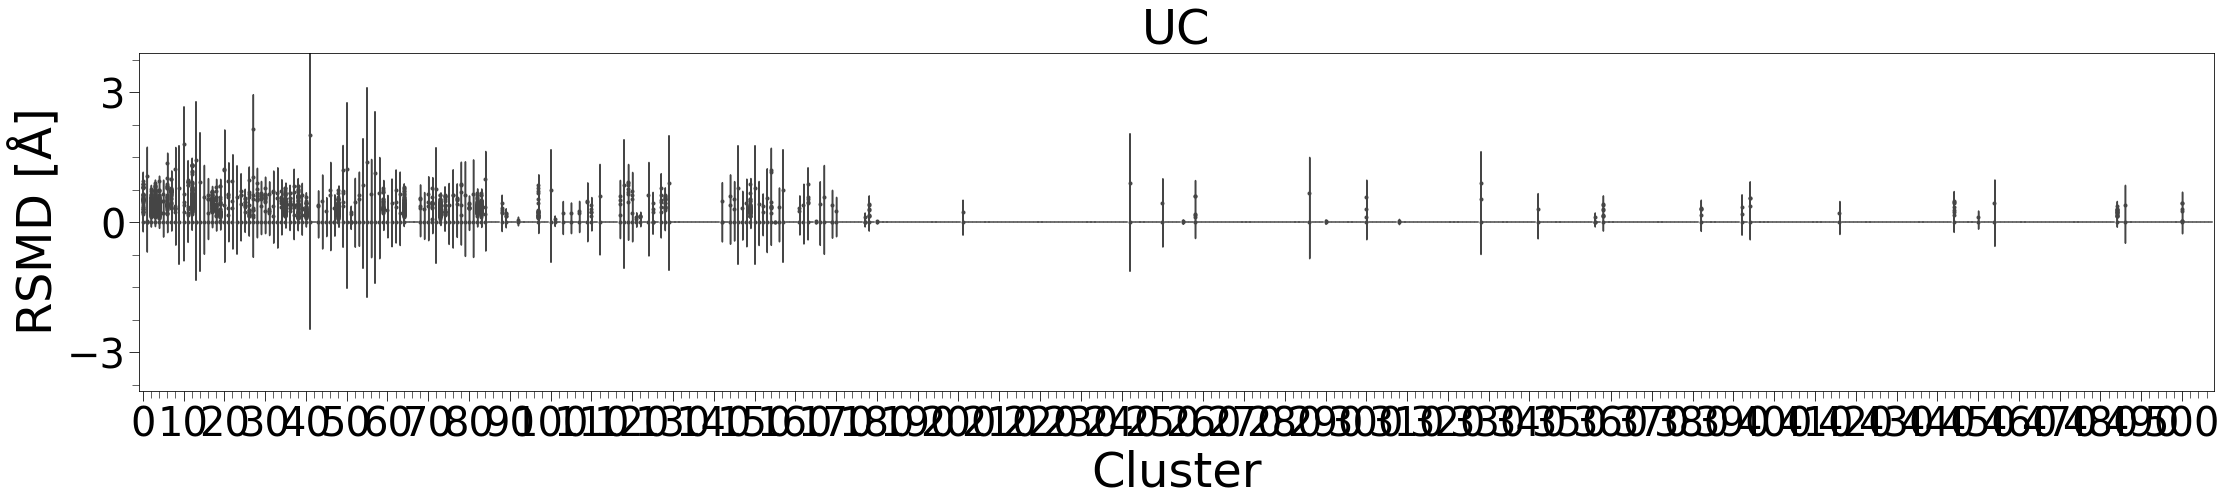

UA: 5146 files found
cluster #(array([0, 1]),): Found 3 samples but more than one index was assigned as centroid (380)
array: [0.06423301 0.06423301 0.12846597]
centroid_feature: [0.35902801 0.30445054 0.40569377 0.60646439 0.49086866 0.84118038
 0.72179812 0.91685861 1.43155158 0.2787061  0.56919026 0.79398704
 0.16130556 0.57610059 0.60682207 0.75269145 1.1534884  0.38940832
 0.74865752 0.33574858 0.6915589  0.59908813 0.8232224  1.19429767
 0.45141923 0.6170857  0.78945667 0.51911145 0.7704882  1.2950455
 0.85563803 0.91864657 0.64489603 0.78120297 1.49835479 0.44804335
 0.53542215 0.66373056 1.00331593 0.35754311 0.30715767 0.67172718
 0.27291727 0.85489279 0.78667426]
feature1: [0.36018154 0.30728903 0.40618166 0.61017466 0.495114   0.6253394
 0.8870855  0.93403715 0.8562821  0.27857658 0.5740516  0.78439915
 0.16052529 0.46416503 0.6001172  0.7311985  0.8848857  0.392282
 0.74672735 0.39831758 0.37391332 0.65387    0.6770359  0.8428359
 0.45194885 0.6477187  0.48471454 0.8216162 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789
# of samples,78.0,104.0,2.0,16.0,57.0,3.0,131.0,14.0,7.0,116.0,56.0,3.0,2.0,2.0,4.0,22.0,6.0,976.0,5.0,96.0,5.0,9.0,6.0,5.0,2.0,37.0,2.0,129.0,5.0,6.0,4.0,4.0,3.0,156.0,3.0,8.0,68.0,2.0,10.0,24.0,19.0,8.0,2.0,4.0,3.0,7.0,15.0,58.0,5.0,31.0,6.0,255.0,8.0,2.0,3.0,34.0,3.0,34.0,3.0,16.0,3.0,2.0,2.0,4.0,5.0,30.0,3.0,4.0,2.0,18.0,10.0,9.0,9.0,5.0,4.0,2.0,148.0,3.0,3.0,3.0,4.0,31.0,2.0,2.0,7.0,12.0,2.0,3.0,16.0,26.0,2.0,15.0,4.0,5.0,3.0,2.0,104.0,4.0,6.0,8.0,4.0,2.0,9.0,189.0,11.0,2.0,8.0,10.0,499.0,2.0,2.0,2.0,2.0,5.0,6.0,1.0,3.0,1.0,2.0,2.0,69.0,2.0,7.0,3.0,27.0,2.0,2.0,1.0,1.0,1.0,2.0,5.0,7.0,2.0,2.0,5.0,2.0,36.0,1.0,3.0,1.0,43.0,16.0,2.0,2.0,3.0,3.0,4.0,2.0,2.0,4.0,1.0,2.0,2.0,4.0,5.0,2.0,7.0,2.0,1.0,2.0,2.0,3.0,3.0,16.0,1.0,1.0,4.0,2.0,9.0,1.0,1.0,4.0,4.0,2.0,6.0,2.0,2.0,12.0,1.0,143.0,2.0,5.0,3.0,8.0,2.0,12.0,2.0,6.0,10.0,1.0,3.0,2.0,9.0,2.0,6.0,6.0,1.0,4.0,4.0,11.0,1.0,1.0,4.0,11.0,2.0,14.0,9.0,2.0,1.0,4.0,27.0,1.0,2.0,1.0,7.0,2.0,2.0

<Figure size 4608x576 with 0 Axes>

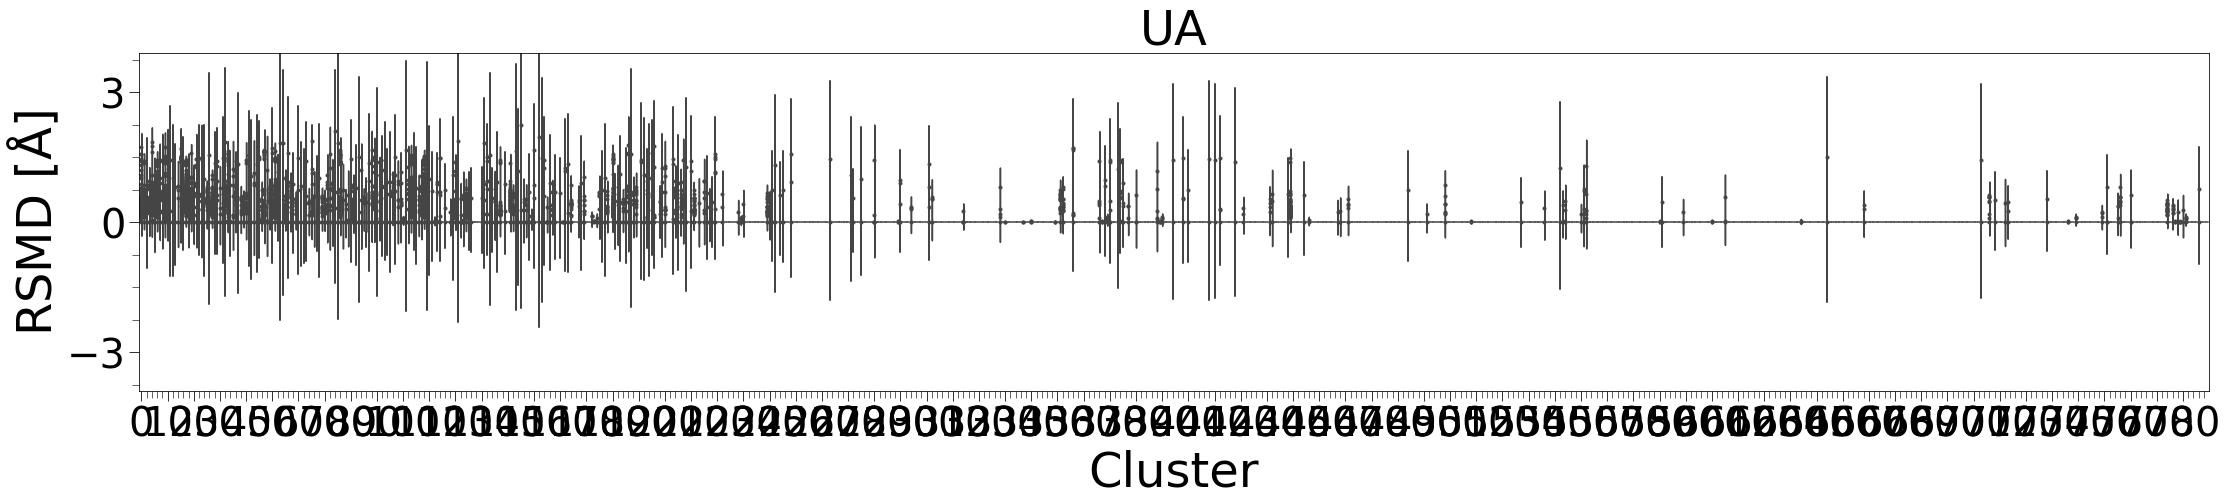

UU: 4093 files found
929 clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928
# of samples,4.0,3.0,2.0,51.0,4.0,2.0,19.0,5.0,3.0,3.0,4.0,2.0,16.0,22.0,17.0,2.0,6.0,104.0,8.0,3.0,80.0,15.0,51.0,2.0,7.0,4.0,75.0,2.0,4.0,29.0,9.0,3.0,4.0,3.0,3.0,5.0,29.0,5.0,45.0,3.0,158.0,6.0,5.0,6.0,11.0,3.0,5.0,5.0,4.0,6.0,4.0,26.0,9.0,3.0,6.0,5.0,15.0,3.0,4.0,8.0,7.0,3.0,207.0,14.0,207.0,2.0,2.0,21.0,2.0,2.0,19.0,3.0,5.0,13.0,3.0,2.0,4.0,1.0,3.0,13.0,1024.0,2.0,4.0,2.0,6.0,12.0,2.0,

<Figure size 4608x576 with 0 Axes>

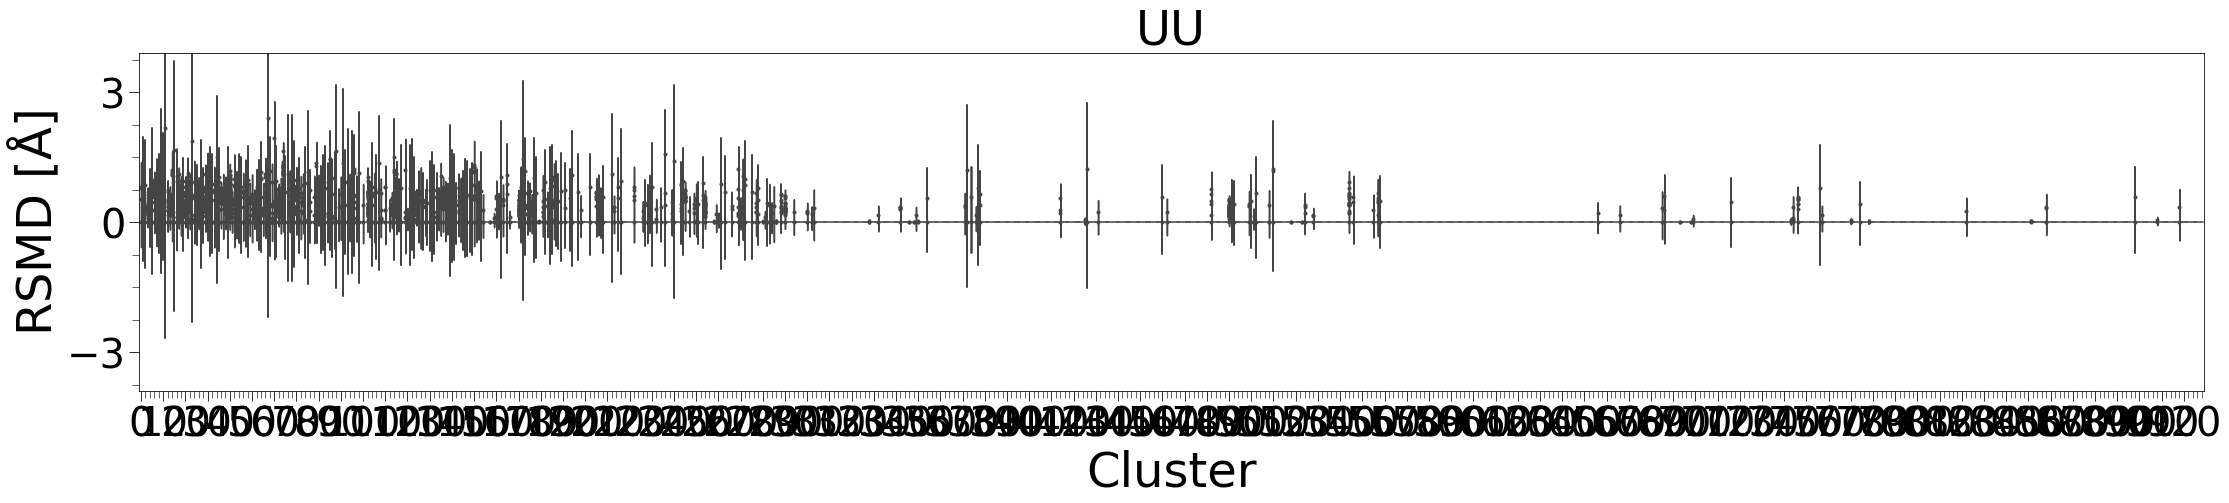

total structures: 18933


<Figure size 4608x576 with 0 Axes>

In [17]:
if __name__ == "__main__":
    
    base_path = os.path.dirname(os.path.abspath("__file__")).strip('notebooks')
    output_path = os.path.join(base_path, "pdb", "motif", "cluster")
    dump_path = os.path.join(output_path, "dump")
    release_versions = [ "HairpinLoopMotifAtlasRelease3.61", "InternalLoopMotifAtlasRelease3.61", "nrlist_3.245_4.0A/JunctionLoop" ]
    
    os.makedirs(os.path.join(dump_path), exist_ok = True)      # dump directory to store removed structures
    
    params = { "method": "average", "threshold": 0.4 }   # uses the average of the distances of each observation of the two sets
    categories = { "doublebase": 2 }

    
    n_total = 0
    for category, n in categories.items():
        arr = get_basesets(categories)
        for seq in arr:
            
            dest_path = os.path.join(output_path, category, seq)
            os.makedirs(dest_path, exist_ok = True)

            _ = [ glob.glob(output_path.strip('cluster') + "/{}/{}/*_{}_*.pdb".format(release_version, category, seq)) for release_version in release_versions ]
            files = list(set([ item for elem in _ for item in elem ]))  # convert nested list into flat list
            print("{}: {} files found".format(seq, len(files)))

            # curate input files
            curated_files = load_file(files, dump_path)

            # calculate features
            #feat_torsion = torsion_featurizer(curated_files)
            feat_dist = dist_featurizer(curated_files, atom_slice_interval=1)
            #feat_concat = np.concatenate((feat_torsion, feat_dist), axis=1)

            #feat = feat_torsion
            feat = feat_dist
            #feat = feat_concat

            # feature scaling
            #feat = StandardScaler().fit_transform(feat)
            #pca = PCA(svd_solver="full")
            #pca.fit(feat)
            #pca_coord = pca.transform(feat)
            #print("# of components: {} -> {} / explained variance: {:.2f}".format(len(feat[1]), pca.n_components_, pca.explained_variance_ratio_.sum()))

            # clustering
            cluster_labels, centroid_indexes = agglomerative_cluster(feat, params)
            #cluster_labels, centroid_indexes = dbscan_cluster(feat, params)

            # export cluster centroids
            n = export_pdb(curated_files, cluster_labels, centroid_indexes, dest_path)
            n_total += n

            # plot rmsd distribution
            cluster_path = os.path.join(output_path, category, seq)
            plot(cluster_path, seq)
                
                
    print("=======================")
    print("total structures: {}".format(n_total))